# **Travel Insurance Customer Claim Prediction Classification**
***

### <div align="center"> 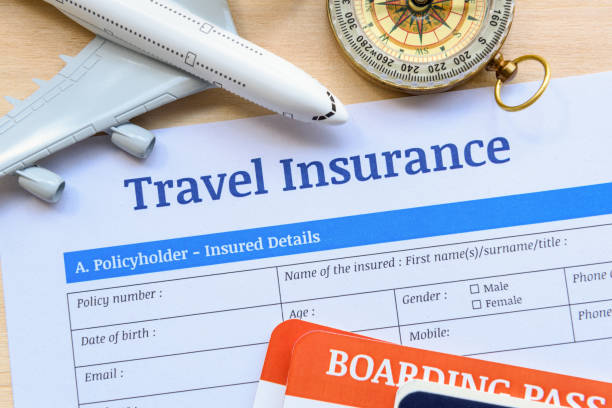 </div>

## **IMPORT MODULE**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
# pd.set_option('display.max_columns', None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_colwidth', 200)
from scipy.stats import normaltest

# Preprocessing
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile

# Imbalance Dataset
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Modeling 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

# Evaluation
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, precision_score, balanced_accuracy_score
from sklearn.metrics import roc_auc_score, RocCurveDisplay

import pickle

## **I. Introduction**

### 1.1 Business Understanding

#### Context
A **travel insurance company** offers a variety of insurance products to customers traveling to different destinations. These products are distributed **through agencies or online** channels, with different **types of plans such as annual coverage, cancellation, and comprehensive insurance**. The company **collects customer data** that includes factors like the **type of agency, distribution channel, product purchased, customer demographics (age and gender), travel duration, and whether an insurance claim was made**. This data also **tracks sales and commission values**.

#### Stakeholder
**Manager of Risk and Claims in the Insurance Department is a key stakeholder** in this project. They are responsible for **assessing risk**, **managing insurance claims**, and **designing strategies** to minimize ***claim-related losses***. This analysis provides the manager with a data-driven approach to **predict whether a customer will file a claim**, allowing them to **adjust product offerings**, **optimize pricing strategies**, and implement **preventative measures** to **improve profitability and risk management**.

### 1.2 Problem Statement
This travel insurance company wants to **predict how likely it is for policyholders to file a claim**, so they can **better manage and allocate funds for coverage**. By preparing the right amount, the company can keep **the claims process smooth** and **avoid having too much unused money** if fewer claims are made.

They also want to **understand the traits of customers who file claims** and find out which **insurance products are less likely to be claimed**. This will help improve the process of **approving policies** and **make product sales more efficient**, allowing the **sales team to target the right customers and boost profits by lowering claim risks**.

### 1.3 Goal
The goal of the company is focusing on **predicting whether a customer will file an insurance claim**. This insight will allow the company to **identify potential high-risk customers**, **better manage claims**, and **optimize pricing and risk mitigation strategies**. 

- How accurately can the company predict whether a customer will file an insurance claim based on their behavior and travel details?
- What patterns in customer purchasing behavior can the company leverage to optimize product offerings and improve sales strategies?

By analyzing patterns in customer behavior and travel details, the company can reduce financial losses from claims and develop more efficient policies. Understanding these trends will help the company improve profitability and provide targeted offers to different customer segments

## **II. Analytical Approach**
The data analysis aims to identify differences in patterns between policyholders who make claims and those who don't, and to understand claim opportunities based on insurance product types. Following this, a classification model will be developed to predict the likelihood of a policyholder filing a claim. The model will use several classification algorithms, including Logistic Regression, Decision Tree, KNN, Random Forest, XGBoost, and LightGBM.

## **III. Metric Evaluation**
- **True Positives (TP)**: Number of policyholders who correctly **filed a claim**.
- **True Negatives (TN)**: Number of policyholders who correctly **did not file a claim**.
- **Type 1 Error (False Positive, FP)**: Number of policyholders incorrectly **predicted to file a claim** when **they did not**. This can lead to idle funds and lost opportunities for the company.
- **Type 2 Error (False Negative, FN)**: Number of policyholders incorrectly **predicted not to file** a claim when **they actually did**. This can result in inadequate funds for claims, damaging the company's reputation and future sales.

To address the risks of **misclassifying positive and negative cases, the model will focus on both classes**. The primary evaluation **metric** will be **ROC/AUC (Receiver Operating Characteristic)**, while **balanced accuracy will be used** instead of overall accuracy due to the **imbalanced** nature of the data. **Several models will be assessed** based on these metrics, and the best-performing **model will be selected for hyperparameter tuning** to further improve its performance.

## **IV. Data Understanding**

This table provides a detailed overview of **travel insurance-related data**, including **agency and distribution details**, **insured individuals' demographic information**, **trip characteristics** such as **destination and duration**, **product and sales performance**, and **claim and commission data**.


| Feature                | Description                                             |
|--------------------------|---------------------------------------------------------|
| Agency                   | Name of the travel insurance agency                     |
| Agency Type              | Type of travel insurance agencies                       |
| Distribution Channel      | Channel of travel insurance agencies                    |
| Product Name             | Name of the travel insurance product                    |
| Gender                   | Gender of the insured                                   |
| Duration                 | Duration of the travel in days                          |
| Destination              | Destination of the travel                               |
| Net Sales                | Amount of sales of travel insurance policies            |
| Commission (in value)    | Commission received by the travel insurance agency      |
| Age                      | Age of the insured                                      |
| Claim                    | Claim status: 0 - No claim, 1 - Claimed                 |

In [126]:
# Read data travel insurance
ti=pd.read_csv('data_travel_insurance.csv')
ti.head(5)

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,No


In [128]:
# Columns Name
ti.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Gender', 'Duration', 'Destination', 'Net Sales',
       'Commision (in value)', 'Age', 'Claim'],
      dtype='object')

In [130]:
# Number of Row and Columns
print(f"Number of rows in dataset is: {ti.shape[0]}")
print(f"Number of columns in dataset is: {ti.shape[1]}\n")

# Info and Unique of dataset
listItem = []
for col in ti.columns :
    listItem.append([col, ti[col].dtype, ti[col].isna().sum(), round((ti[col].isna().sum()/len(ti[col])) * 100,2),
                    ti[col].nunique(), list(ti[col].drop_duplicates().values)]);

ti_unique = pd.DataFrame(columns=['Features', 'Data_Type', 'null', 'nullPct', 'nunique', 'Unique'],
                     data=listItem)
ti_unique

# Data description
print('Unique Table:')
display(ti_unique)
print('Numerical Data Description:')
display(ti.describe())
print('Categorical Data Description:')
display(ti.describe(include='object'))

Number of rows in dataset is: 44328
Number of columns in dataset is: 11

Unique Table:


,Features,Data_Type,null,nullPct,nunique,Unique
0,Agency,object,0,0.00,16,"[C2B, EPX, JZI, CWT, LWC, ART, CSR, SSI, RAB, KML, TST, TTW, JWT, ADM, CCR, CBH]"
1,Agency Type,object,0,0.00,2,"[Airlines, Travel Agency]"
2,Distribution Channel,object,0,0.00,2,"[Online, Offline]"
3,Product Name,object,0,0.00,26,"[Annual Silver Plan, Cancellation Plan, Basic Plan, 2 way Comprehensive Plan, Bronze Plan, 1 way Comprehensive Plan, Rental Vehicle Excess Insurance, Single Trip Travel Protect Gold, Silver Plan, ..."
4,Gender,object,31647,71.39,2,"[F, nan, M]"
5,Duration,int64,0,0.00,437,"[365, 4, 19, 20, 8, 2, 25, 90, 24, 43, 103, 376, 6, 16, 27, 34, 3, 14, 12, 31, 5, 7, 56, 29, 30, 58, 9, 38, 42, 11, 13, 40, 79, 370, 366, 26, 83, 55, 18, 100, 1, 35, 36, 75, 23, 73, 32, 232, 37, 1..."
6,Destination,object,0,0.00,138,"[SINGAPORE, MALAYSIA, INDIA, UNITED STATES, KOREA, REPUBLIC OF, THAILAND, GERMANY, JAPAN, INDONESIA, VIET NAM, AUSTRALIA, FINLAND, UNITED KINGDOM, SRI LANKA, SPAIN, HONG KONG, MACAO, CHINA, UNITED..."
7,Net Sales,float64,0,0.00,1006,"[216.0, 10.0, 22.0, 112.0, 16.0, 50.0, 78.0, 80.0, 40.0, 26.0, 252.85, 47.0, 25.0, 23.0, 20.0, 30.0, 42.0, 56.0, 19.8, 14.0, 29.7, 36.0, 31.0, 58.0, 9.9, 15.0, 21.0, 29.0, 32.0, 125.0, 48.0, 0.0, ..."
8,Commision (in value),float64,0,0.00,915,"[54.0, 0.0, 7.7, 4.0, 9.1, 63.21, 10.5, 11.88, 17.82, 23.4, 7.5, 5.94, 43.75, 23.76, 7.36, 132.99, 9.57, 7.64, 12.25, 29.7, 6.3, 5.63, 41.58, 5.25, 0.09, 6.0, 136.62, 31.53, 54.19, 11.55, 10.15, 4..."
9,Age,int64,0,0.00,89,"[57, 33, 26, 59, 28, 36, 22, 39, 27, 48, 43, 51, 65, 47, 35, 54, 23, 46, 58, 42, 31, 29, 37, 68, 8, 32, 61, 49, 56, 25, 50, 34, 38, 44, 118, 45, 53, 20, 30, 41, 69, 52, 40, 70, 76, 74, 66, 63, 55,..."


Numerical Data Description:


,Duration,Net Sales,Commision (in value),Age
count,44328.000000,44328.000000,44328.000000,44328.000000
mean,49.424292,40.550948,9.707692,39.925600
std,109.153961,48.661970,19.625637,13.954926
min,-1.000000,-357.500000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.500000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


Categorical Data Description:


,Agency,Agency Type,Distribution Channel,Product Name,Gender,Destination,Claim
count,44328,44328,44328,44328,12681,44328,44328
unique,16,2,2,26,2,138,2
top,EPX,Travel Agency,Online,Cancellation Plan,M,SINGAPORE,No
freq,24656,32113,43572,12979,6504,9267,43651


## **V. Exploratory Data Analysis (EDA)**

### 5.1 Numerical Univariate

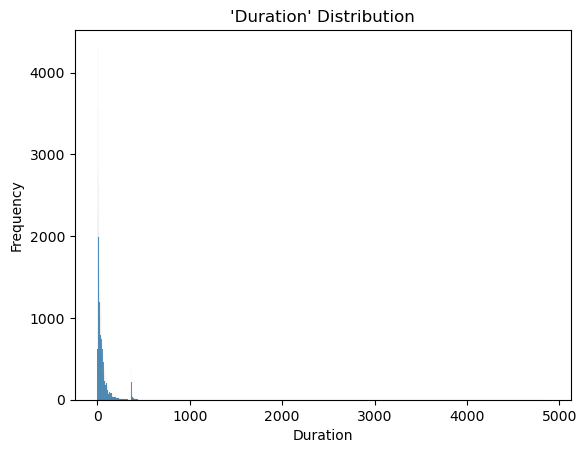

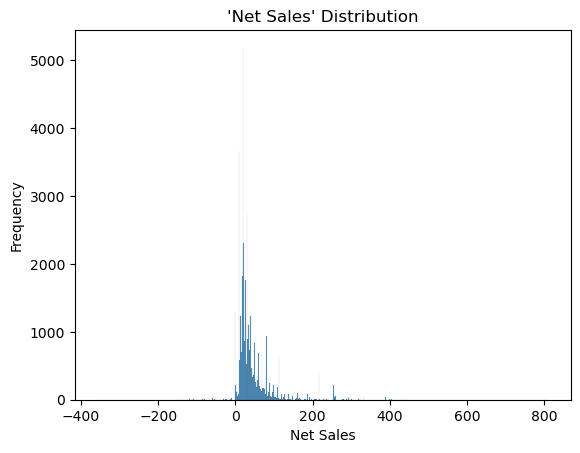

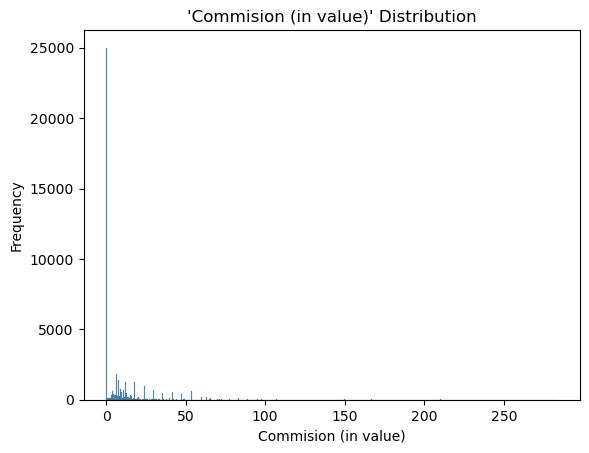

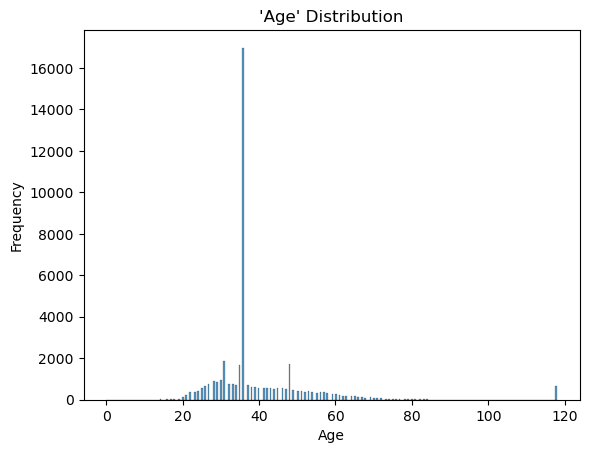

In [134]:
ti_num = ti.select_dtypes(include = 'number')
for x in ti_num.columns:
    sns.histplot(ti_num[x])
    plt.title(f"'{x}' Distribution")
    plt.ylabel('Frequency', size=10)
    plt.show()

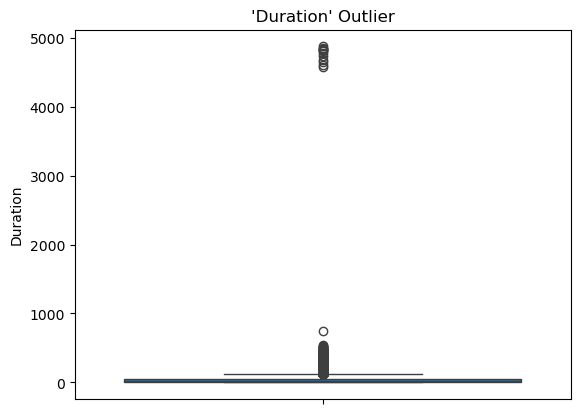

count    44328.000000
mean        49.424292
std        109.153961
min         -1.000000
25%          9.000000
50%         22.000000
75%         53.000000
max       4881.000000
Name: Duration, dtype: float64
Upperlimit: 119
Lowerlimit: -1
Outlier:
count: 3869
proportion: 0.0873


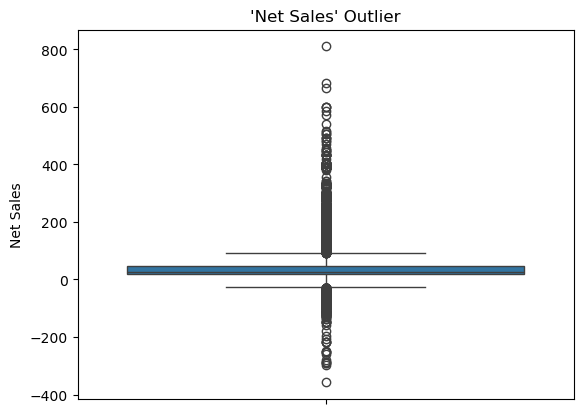

count    44328.000000
mean        40.550948
std         48.661970
min       -357.500000
25%         18.000000
50%         26.500000
75%         48.000000
max        810.000000
Name: Net Sales, dtype: float64
Upperlimit: 93.0
Lowerlimit: -27.0
Outlier:
count: 3879
proportion: 0.0875


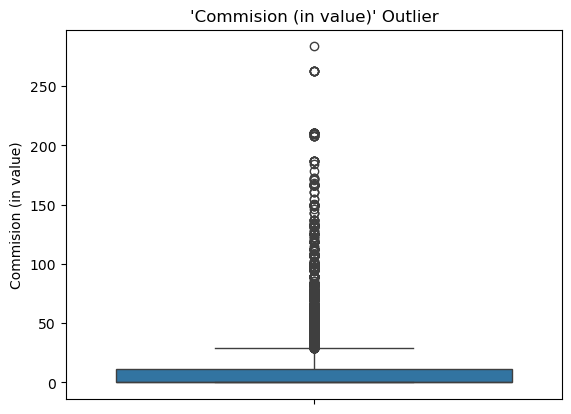

count    44328.000000
mean         9.707692
std         19.625637
min          0.000000
25%          0.000000
50%          0.000000
75%         11.550000
max        283.500000
Name: Commision (in value), dtype: float64
Upperlimit: 28.8
Lowerlimit: 0.0
Outlier:
count: 4909
proportion: 0.1107


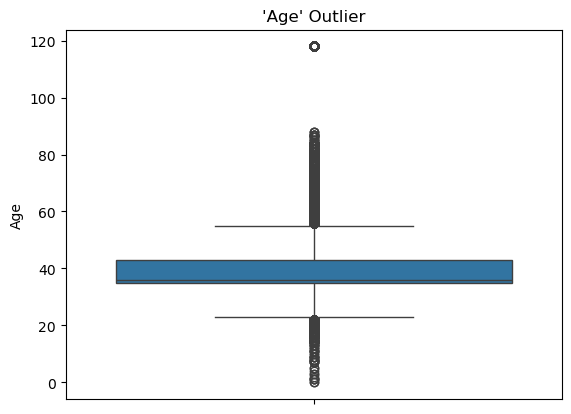

count    44328.000000
mean        39.925600
std         13.954926
min          0.000000
25%         35.000000
50%         36.000000
75%         43.000000
max        118.000000
Name: Age, dtype: float64
Upperlimit: 55
Lowerlimit: 23
Outlier:
count: 5196
proportion: 0.1172


In [135]:
for x in ti_num.columns:
    sns.boxplot(y=ti_num[x])
    plt.title(f"'{x}' Outlier")
    plt.show()
    # statistic metrics
    print(ti_num[x].describe())
    q1 = np.percentile(ti_num[x], 25)
    q3 = np.percentile(ti_num[x], 75)
    iqr = q3-q1
    upperbound = q3+1.5*iqr
    lowerbound = q1-1.5*iqr
    upperlimit = np.max(ti_num[x][ti_num[x]<=upperbound])
    lowerlimit = np.min(ti_num[x][ti_num[x]>=lowerbound])
    print(f'Upperlimit: {upperlimit}')
    print(f'Lowerlimit: {lowerlimit}')
    outlier = ti_num[x][(ti_num[x]>upperbound) | (ti_num[x]<lowerbound)]
    print(f'Outlier:')
    print(f'count: {len(outlier)}')
    print(f'proportion: {round(len(outlier)/len(ti_num[x]),4)}')

### 5.2 Categorical Univariate

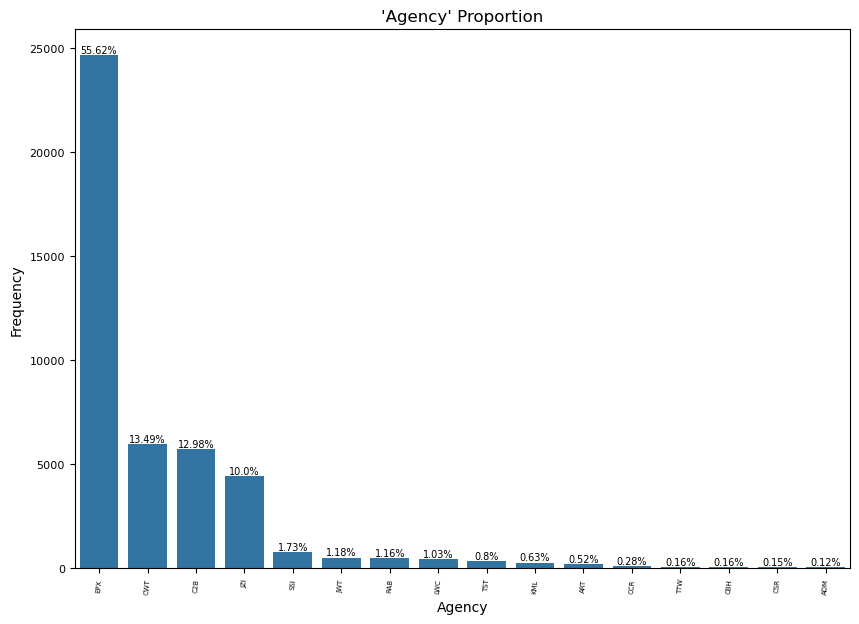

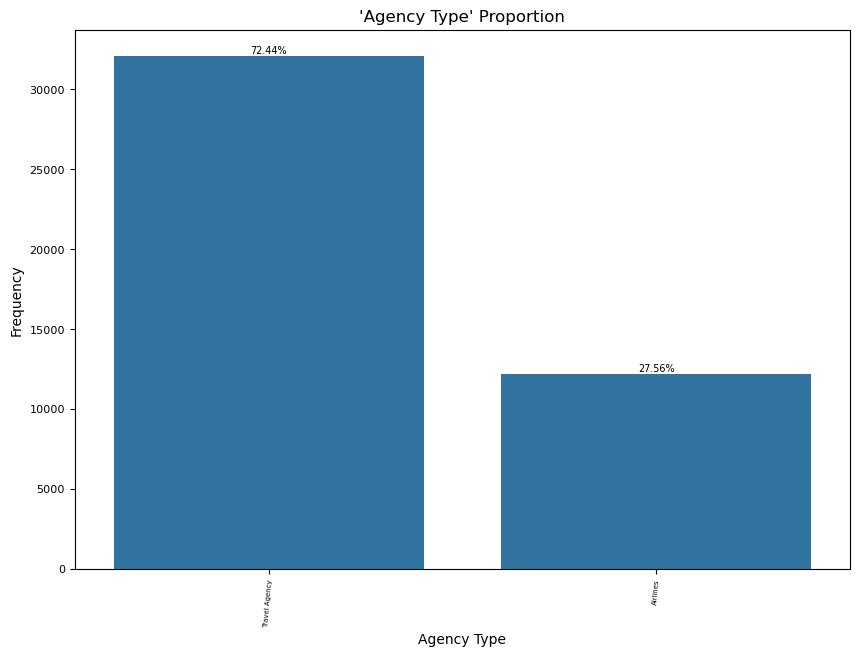

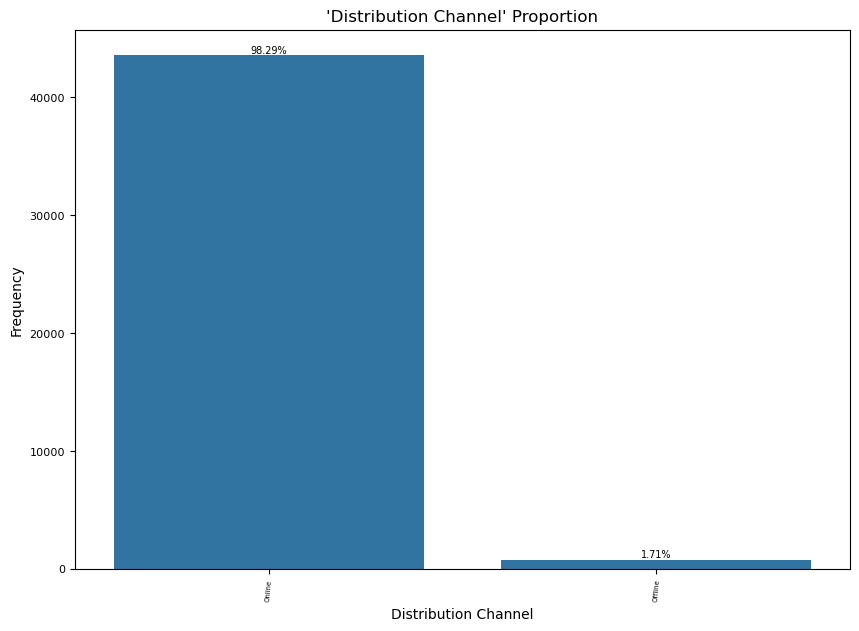

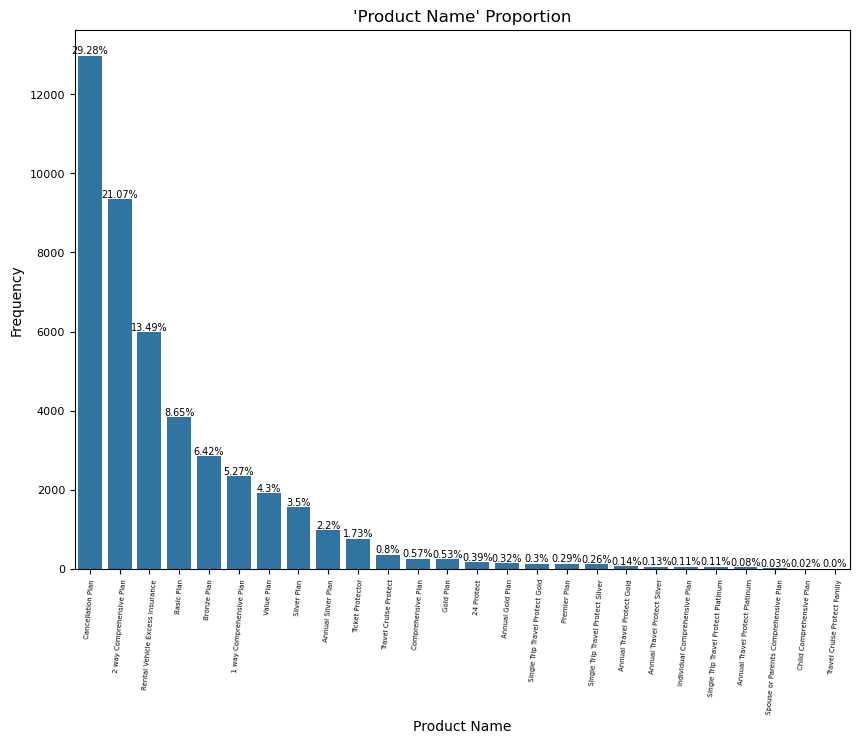

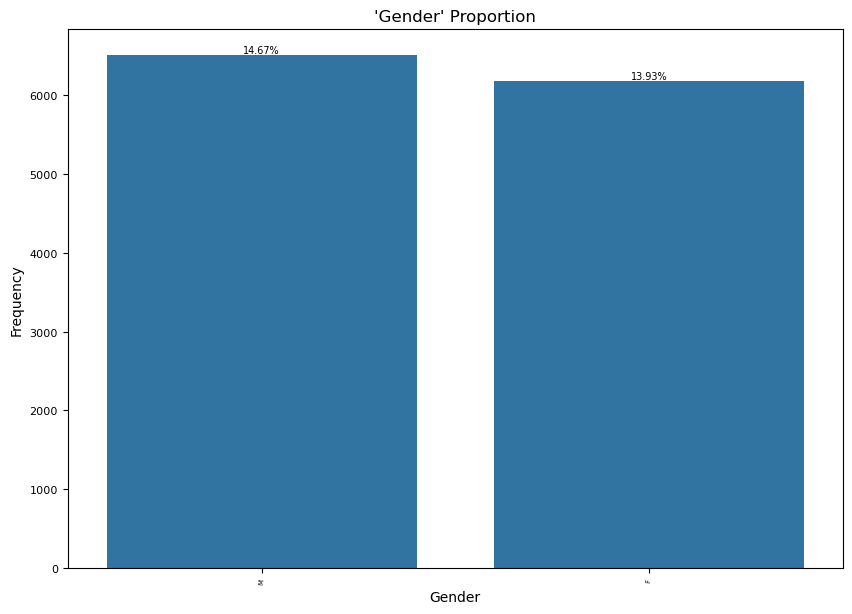

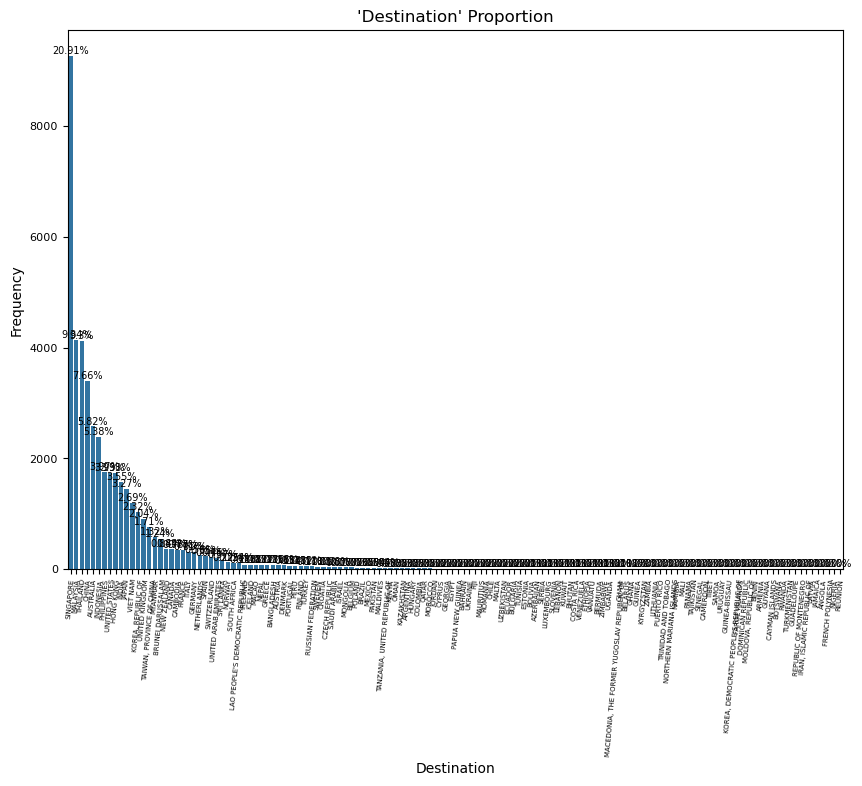

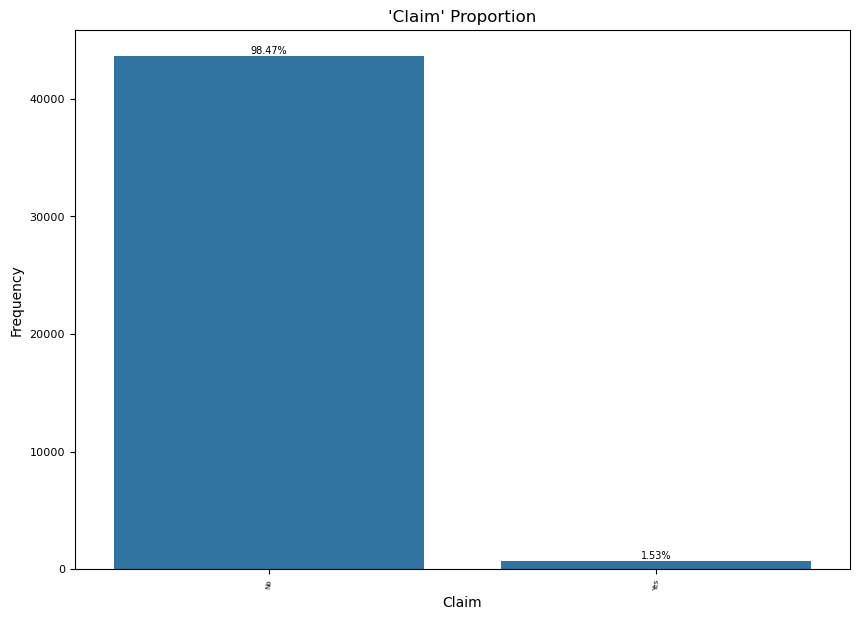

In [137]:
ti_obj = ti.select_dtypes(include='object')
for x in ti_obj:
    plt.figure(figsize=(10, 7), dpi=100)
    count_values = ti_obj[x].value_counts(ascending=False)
    ax = sns.countplot(data=ti_obj, x=x, order=count_values.index)
    plt.xticks(rotation=85,size=5)
    plt.ylabel('Frequency',size=10)
    plt.yticks(size=8)
    rel_values = count_values.values / len(ti_obj) * 100
    lbls = [f'{round(p,2)}%' for p in rel_values]
    
    if len(ax.containers[0]) == len(lbls):
        ax.bar_label(container=ax.containers[0], labels=lbls, fontsize=7)
    else:
        print(f'Warning: number of bars ({len(ax.containers[0])}) and labels ({len(lbls)}) do not match.')
    
    plt.title(f"'{x}' Proportion")
    plt.show()

### 5.3 EDA Multivariate(Numerical-Categorical (Label))

In [139]:
ti_label = ti.select_dtypes(include = 'number')
ti_label

,Duration,Net Sales,Commision (in value),Age
0,365,216.0,54.00,57
1,4,10.0,0.00,33
2,19,22.0,7.70,26
3,20,112.0,0.00,59
4,8,16.0,4.00,28
...,...,...,...,...
44323,14,30.0,0.00,36
44324,17,79.2,47.52,47
44325,64,30.0,10.50,50
44326,51,36.0,0.00,36


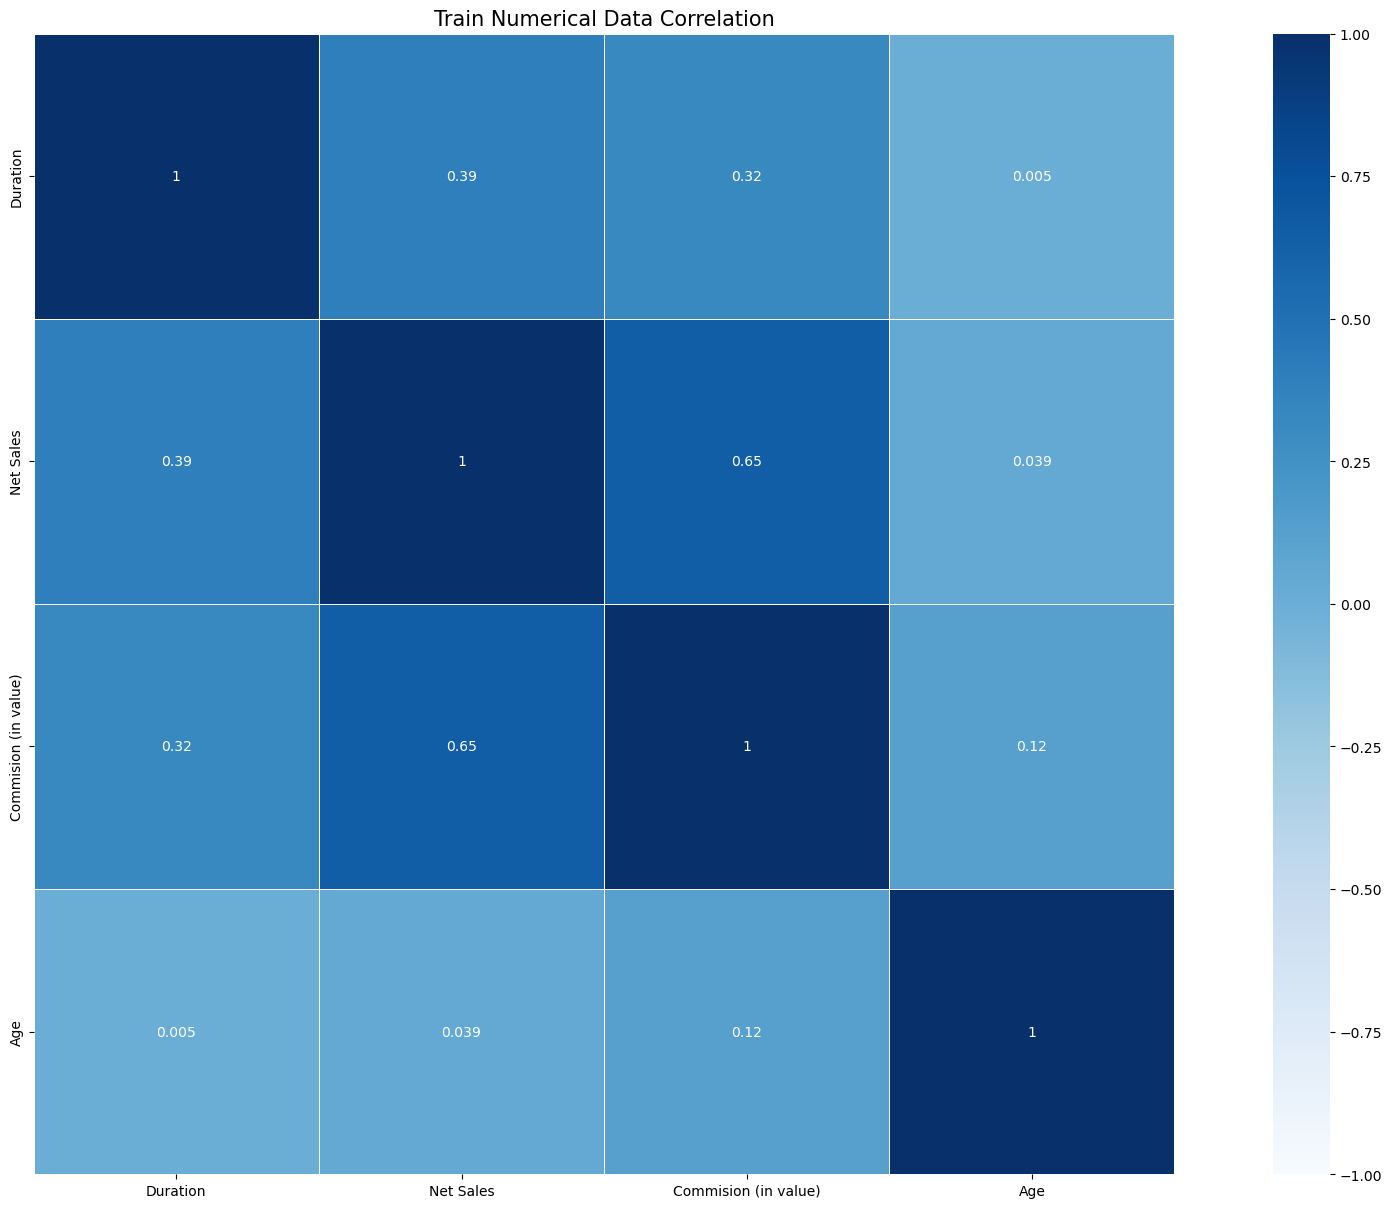

In [140]:
corr = ti_num.corr()
plt.figure(figsize=(20,12))
sns.heatmap(corr, cmap='Blues', annot=True, center=0, vmin=-1, square=True, linewidths=.5)
plt.tight_layout()
plt.title('Train Numerical Data Correlation',size=15)
plt.show()

### 5.4 Multivariate : Categorical vs Categorical

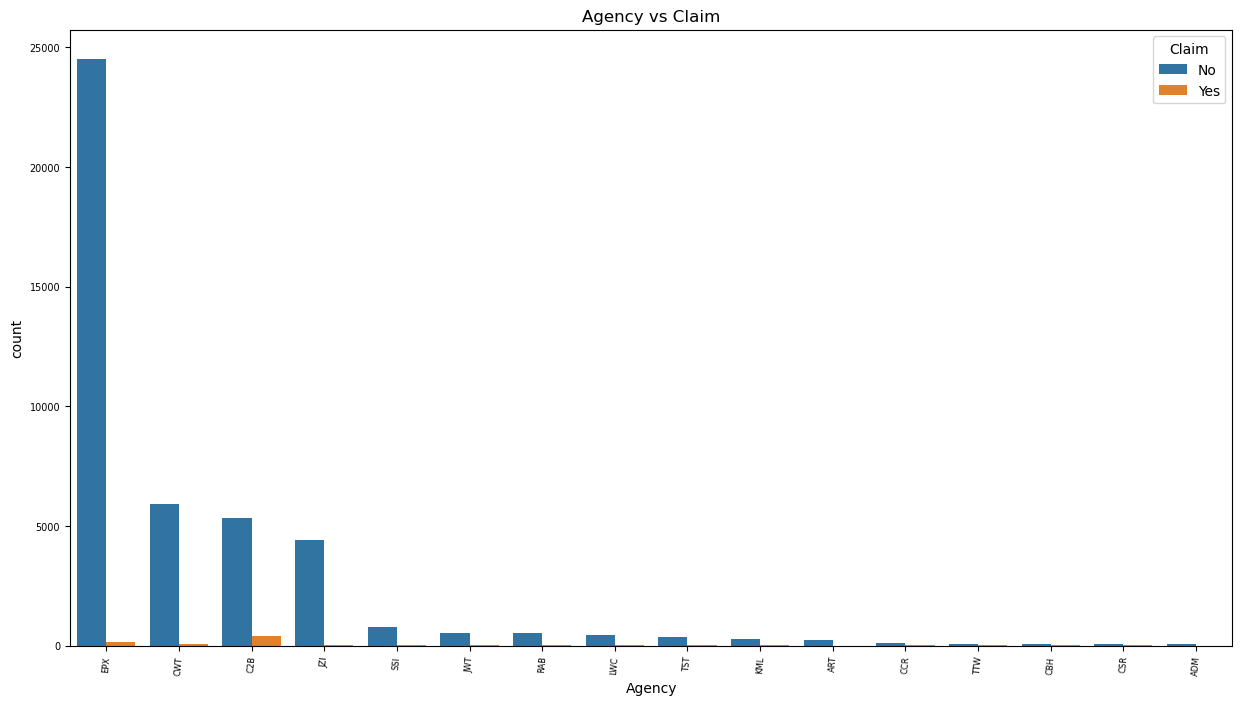

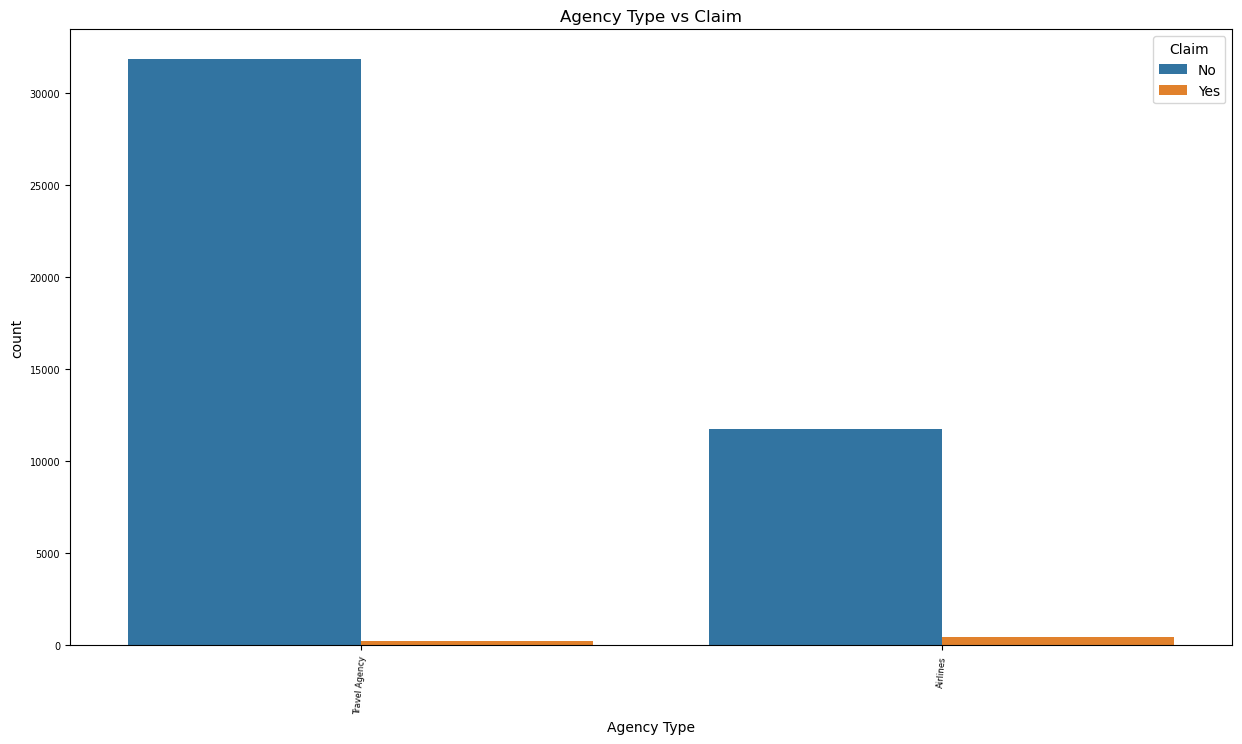

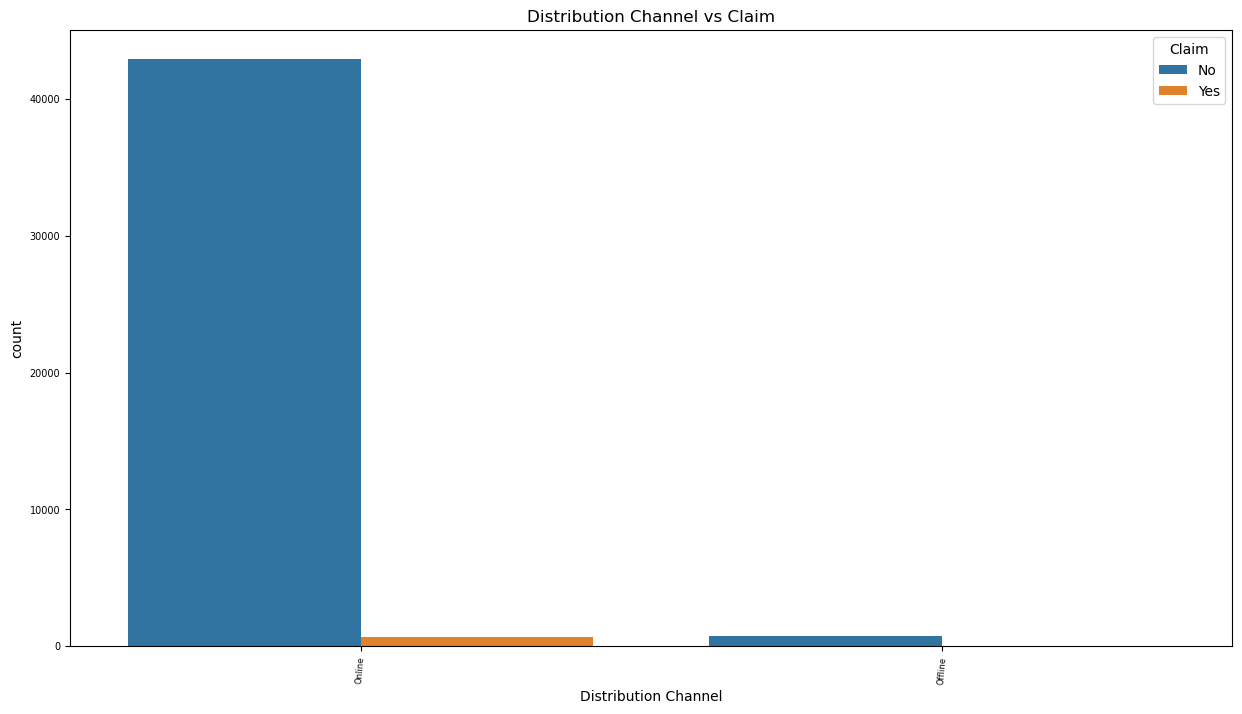

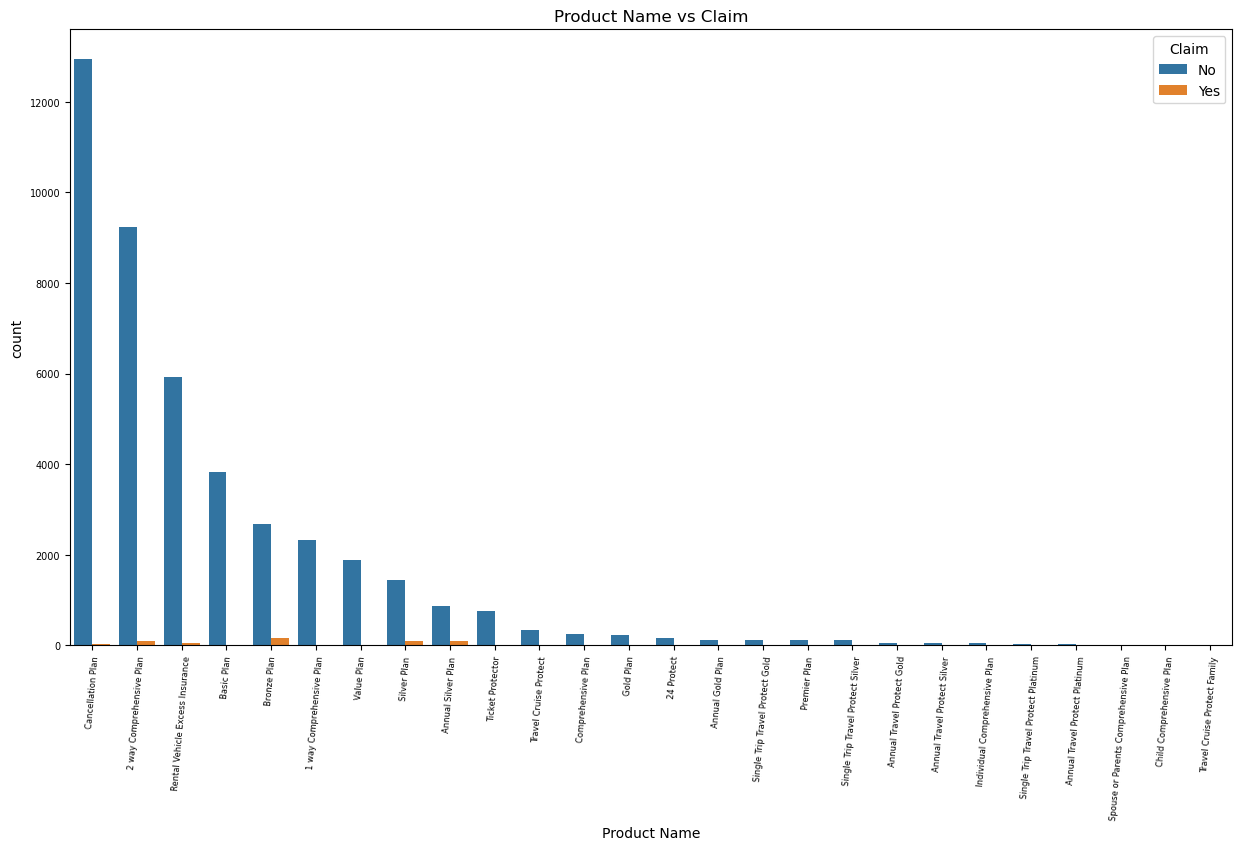

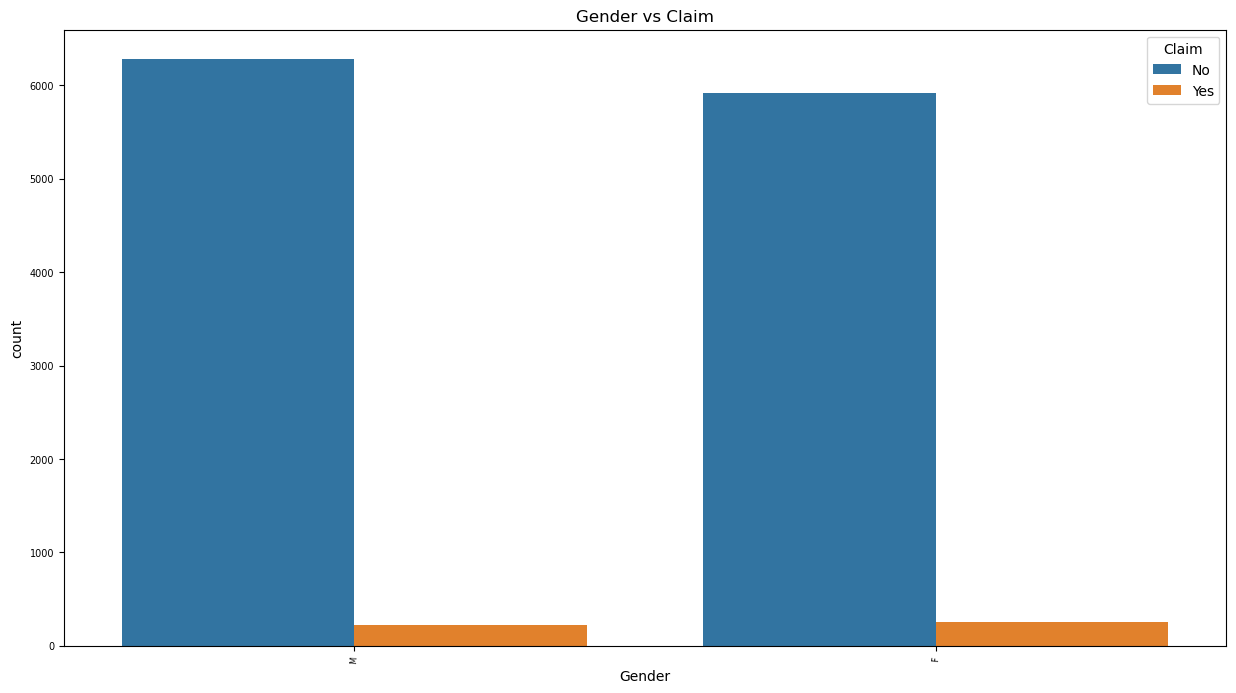

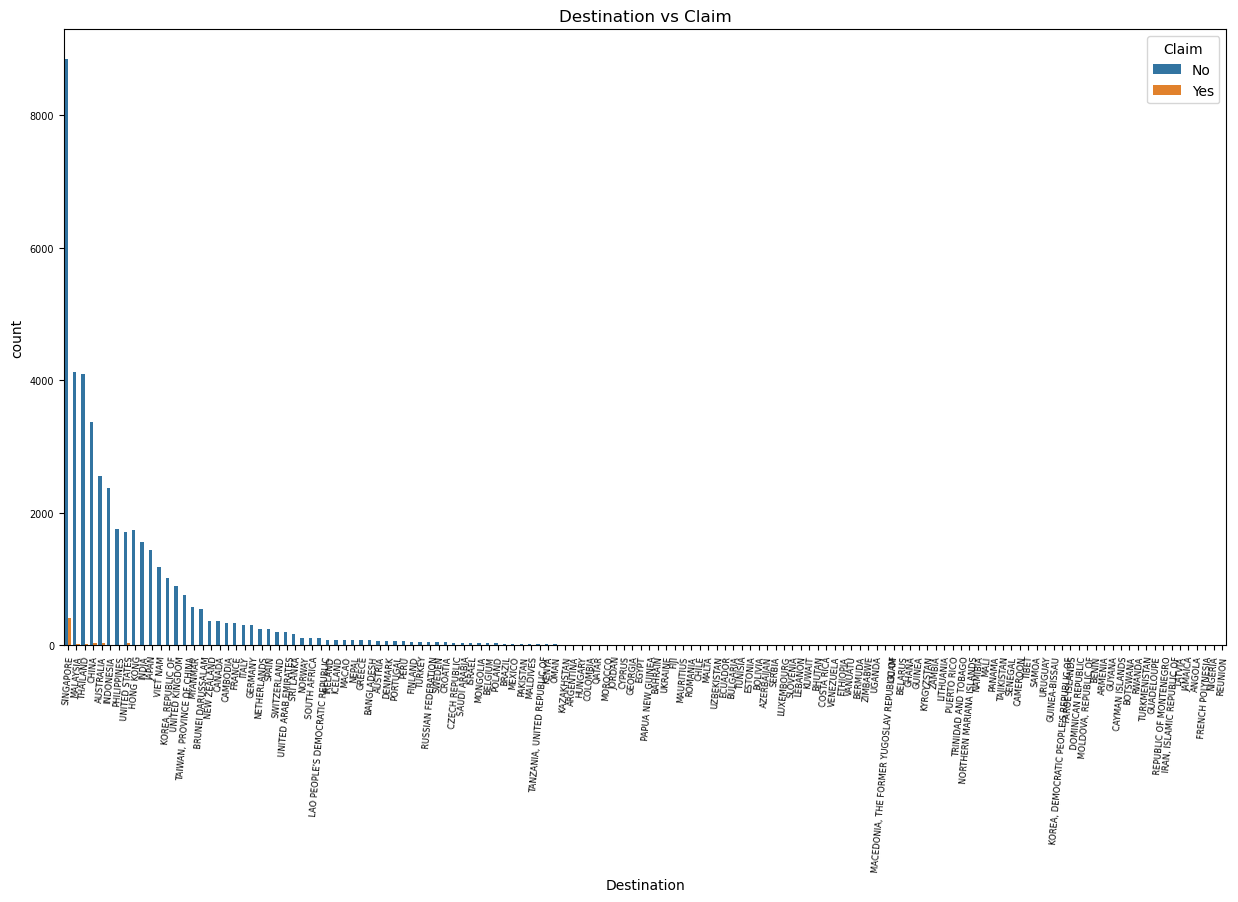

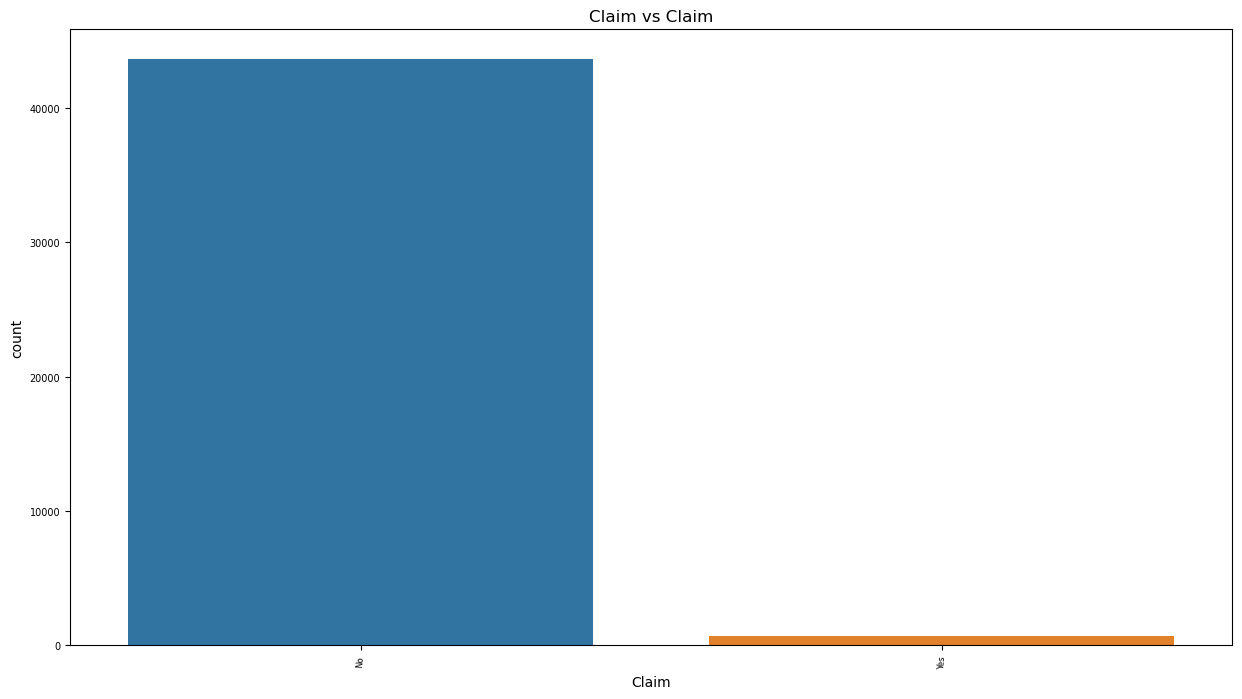

In [142]:
for x in ti.select_dtypes(include='object'):
    plt.figure(figsize=(15, 8), dpi=100)
    count_values = ti[x].value_counts(ascending=False)
    ax = sns.countplot(data=ti, x=x, hue='Claim',order=count_values.index)
    plt.xticks(rotation=85, size=6)
    plt.yticks(size=7)
    plt.title(f'{x} vs Claim')
    plt.show()

### 5.5 Check Imbalance Data

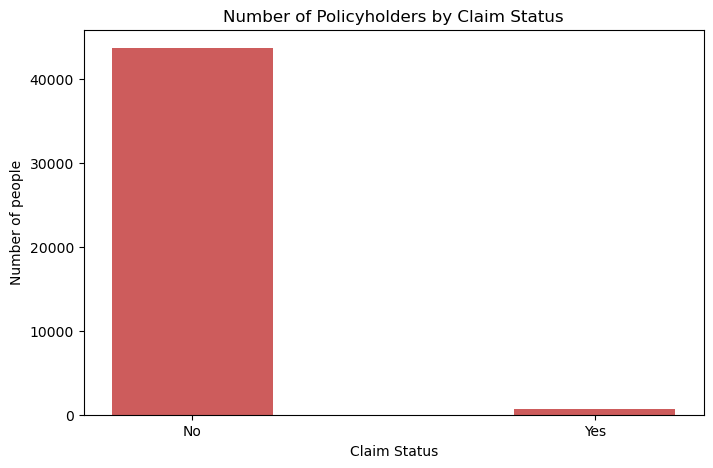

Number of policyholders filling claims: 677
Number of policyholders who did not file a claim: 43651



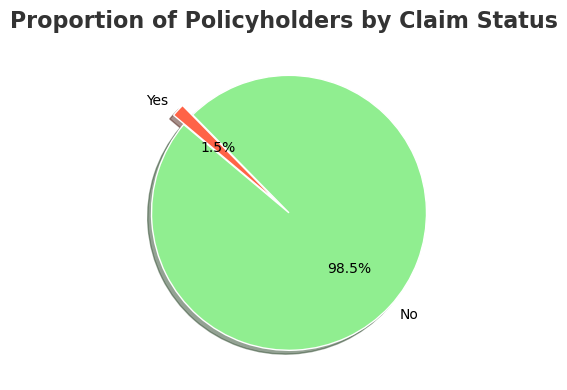

Claim percentage: 1.53 %
Non-claim percentage: 98.47 %


In [144]:
# Claim Status Visualization with Bar Plot
claim = ti.groupby(by=['Claim']).size().reset_index(name='counts')
plt.figure(figsize=(8, 5))
plt.bar(claim['Claim'], claim['counts'], color ='indianred', width = 0.4)
plt.xticks([0, 1], ['No', 'Yes'])
plt.xlabel('Claim Status')
plt.ylabel('Number of people')
plt.title('Number of Policyholders by Claim Status')
plt.show()

# Check Data Balance/Imbalance
yes = ti[ti['Claim'] == "Yes"].count()[1]
no = ti[ti['Claim'] == "No"].count()[1]
print(f'Number of policyholders filling claims: {yes}')
print(f'Number of policyholders who did not file a claim: {no}\n')

claim = ti.groupby(by=['Claim']).size().reset_index(name='counts')

claim_labels = ["No", "Yes"]
colors = ['lightgreen', 'tomato']
explode = (0.05, 0.05)

plt.figure(figsize=(8, 4))
plt.pie(
    claim['counts'], 
    labels=claim_labels, 
    autopct='%1.1f%%', 
    colors=colors,  
    startangle=140, 
    explode=explode,
    shadow=True, 
    wedgeprops=dict(edgecolor='w', linewidth=1)
)

# Add title and layout adjustments
plt.title('Proportion of Policyholders by Claim Status', fontsize=16, fontweight='bold', color='#333333')
plt.tight_layout()
plt.show()

# Cheking claim percentage 
print(f'Claim percentage: {round((yes/(yes+no)*100),2)} %')
print(f'Non-claim percentage: {round((no/(yes+no)*100),2)} %')

`Summary`

The data is **imbalanced**, with only **1.53 %** of policyholders **filling claims** and **98.47 %** **not filling claims**. To address this, **SMOTE** (Synthetic Minority Over-sampling Technique) will be used **to balance the data** before modeling. **Simple oversampling is avoided to prevent overfitting from data duplication**, and **undersampling is not recommended due to the small number of claim** cases (**677 out of 43651**), as it risks losing valuable information and reducing model performance.

## **VI. Data Preparation**

### 6.1 Handling Missing Value

In [34]:
# Calculate Null
null_data = ti.isna().sum().reset_index().rename(columns={'index':'variable', 0:'null count'})
# Calculate Percentage Null
null_data['null percentage'] = null_data['null count'].apply(lambda x: (x/(ti.shape[0]))*100)
null_data

,variable,null count,null percentage
0,Agency,0,0.000000
1,Agency Type,0,0.000000
2,Distribution Channel,0,0.000000
3,Product Name,0,0.000000
4,Gender,31647,71.392799
5,Duration,0,0.000000
6,Destination,0,0.000000
7,Net Sales,0,0.000000
8,Commision (in value),0,0.000000
9,Age,0,0.000000


`Summary`

The "Gender" column has a high percentage of missing values (71.39%), making it challenging to classify policyholders who make claims based on gender. Moreover, including gender in machine learning models is not recommended due to AI Ethics, which prioritize fairness by preventing discrimination based on gender, religion, ethnicity, or any group in decision-making. As a result, the "Gender" column will be removed.

Reference: **General Data Protection Regulation (GDPR)**

In [36]:
# Drop gender
ti.drop(['Gender'], axis=1, inplace=True)
ti.head(1)

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.0,57,No


### 6.2 Handling Duplicates

In [38]:
# Check number of rows & columns
print('Number rows of before Handling Duplicates:', ti.shape[0])
print('Number columns of after Handling Duplicates:', ti.shape[1])
print('The amount of data that has duplicates:', ti.duplicated().sum())

Number rows of before Handling Duplicates: 44328
Number columns of after Handling Duplicates: 10
The amount of data that has duplicates: 5004


In [39]:
# Detecting duplicate
duplicate = ti.duplicated()
ti[duplicate]

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
331,EPX,Travel Agency,Online,Cancellation Plan,2,SINGAPORE,10.0,0.00,36,No
360,EPX,Travel Agency,Online,Cancellation Plan,6,MALAYSIA,10.0,0.00,36,No
473,EPX,Travel Agency,Online,Cancellation Plan,11,MALAYSIA,10.0,0.00,36,No
488,EPX,Travel Agency,Online,Cancellation Plan,2,SINGAPORE,10.0,0.00,36,No
636,EPX,Travel Agency,Online,1 way Comprehensive Plan,3,MALAYSIA,20.0,0.00,36,No
...,...,...,...,...,...,...,...,...,...,...
44309,EPX,Travel Agency,Online,2 way Comprehensive Plan,49,VIET NAM,20.0,0.00,36,No
44311,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,5,THAILAND,29.7,17.82,38,No
44313,EPX,Travel Agency,Online,Cancellation Plan,5,CHINA,14.0,0.00,36,No
44315,EPX,Travel Agency,Online,1 way Comprehensive Plan,5,THAILAND,20.0,0.00,36,No


In [40]:
# Create DataFrame
df = pd.DataFrame(ti)

# Define the specific row values
specific_row = {
    'Agency': 'EPX',
    'Agency Type': 'Travel Agency',
    'Distribution Channel': 'Online',
    'Product Name': 'Cancellation Plan',
    'Duration': 2,
    'Destination': 'SINGAPORE',
    'Net Sales': 10.0,
    'Commision (in value)': 0.00,
    'Age': 36
}

# Filter rows that match the specific values
matching_rows = df[
    (df['Agency'] == specific_row['Agency']) &
    (df['Agency Type'] == specific_row['Agency Type']) &
    (df['Distribution Channel'] == specific_row['Distribution Channel']) &
    (df['Product Name'] == specific_row['Product Name']) &
    (df['Duration'] == specific_row['Duration']) &
    (df['Destination'] == specific_row['Destination']) &
    (df['Net Sales'] == specific_row['Net Sales']) &
    (df['Commision (in value)'] == specific_row['Commision (in value)']) &
    (df['Age'] == specific_row['Age'])
]

# Count how many times this row appears
count_duplicates = matching_rows.shape[0]

print(f"Count of duplicate rows matching the specific values: {count_duplicates}")
display(matching_rows)

Count of duplicate rows matching the specific values: 41


,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
5,EPX,Travel Agency,Online,Cancellation Plan,2,SINGAPORE,10.0,0.0,36,No
331,EPX,Travel Agency,Online,Cancellation Plan,2,SINGAPORE,10.0,0.0,36,No
488,EPX,Travel Agency,Online,Cancellation Plan,2,SINGAPORE,10.0,0.0,36,No
1352,EPX,Travel Agency,Online,Cancellation Plan,2,SINGAPORE,10.0,0.0,36,No
1824,EPX,Travel Agency,Online,Cancellation Plan,2,SINGAPORE,10.0,0.0,36,No
2449,EPX,Travel Agency,Online,Cancellation Plan,2,SINGAPORE,10.0,0.0,36,No
3103,EPX,Travel Agency,Online,Cancellation Plan,2,SINGAPORE,10.0,0.0,36,No
6972,EPX,Travel Agency,Online,Cancellation Plan,2,SINGAPORE,10.0,0.0,36,No
7334,EPX,Travel Agency,Online,Cancellation Plan,2,SINGAPORE,10.0,0.0,36,No
8046,EPX,Travel Agency,Online,Cancellation Plan,2,SINGAPORE,10.0,0.0,36,No


In [41]:
# Remove duplicate data without deleting the original data and reset the data set index.
ti.drop_duplicates(keep='first', inplace=True)
ti = ti.reset_index().drop(columns = {'index'})

# Re-check number of rows & columns
print('Number of rows:', ti.shape[0])
print('Number of columns:', ti.shape[1])

Number of rows: 39324
Number of columns: 10


### 6.3 Handling Invalid Data

**`Duration`**

It was found that the Duration variable contains **negative values**, which is not possible for travel durations. This is likely due to data entry errors. Therefore, all negative values will be **converted to positive**, keeping the magnitude unchanged.

In [44]:
# Check Duration Negative value
ti[ti['Duration']<0]

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
24015,JZI,Airlines,Online,Basic Plan,-1,MALAYSIA,18.0,6.3,118,No
24245,JZI,Airlines,Online,Basic Plan,-1,BRUNEI DARUSSALAM,18.0,6.3,118,No


In [45]:
# Replace values
ti['Duration'] = ti['Duration'].replace([-1], 1)
# Re-check if the negative has been handled
display(ti[ti['Duration']<0])

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim


Another problem with the Duration column is the **abnormal maximum travel duration** value for travel insurance coverage. **After conducting research on travel insurance duration on the [GoCompare](https://www.gocompare.com/travel-insurance/long-stay-cover/#:~:text=Long%2Dstay%20travel%20insurance%20covers,usually%20up%20to%2018%20months.) article**, it is stated that most standard travel insurance only covers up to **31 days**, single-trip travel insurance covers up to **3 months (91 days)**, and for long-term travel insurance generally covers trips lasting up to **18 months (547 days)**. Let's first display data with a duration above 547 days.

In [47]:
invalid_duration = ti[ti['Duration']>547]
invalid_duration

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
87,SSI,Airlines,Online,Ticket Protector,4736,SINGAPORE,0.32,0.09,48,No
4556,SSI,Airlines,Online,Ticket Protector,4857,SINGAPORE,0.32,0.09,48,No
9712,SSI,Airlines,Online,Ticket Protector,4815,SINGAPORE,0.32,0.09,48,No
11510,SSI,Airlines,Online,Ticket Protector,4652,SINGAPORE,0.32,0.09,48,No
18160,SSI,Airlines,Online,Ticket Protector,4881,SINGAPORE,0.13,0.04,48,No
18645,SSI,Airlines,Online,Ticket Protector,4844,SINGAPORE,0.32,0.09,48,No
19983,C2B,Airlines,Online,Annual Silver Plan,740,SINGAPORE,0.00,54.19,36,No
20550,SSI,Airlines,Online,Ticket Protector,4580,SINGAPORE,0.32,0.09,48,No
23479,SSI,Airlines,Online,Ticket Protector,4685,SINGAPORE,0.32,0.09,48,No
25589,SSI,Airlines,Online,Ticket Protector,4829,SINGAPORE,0.32,0.09,48,No


In [48]:
tp = ti[(ti['Duration']<547) & (ti['Product Name'] == 'Ticket Protector')]
asp = ti[(ti['Duration']<547) & (ti['Product Name'] == 'Annual Silver Plan')]

# Duration of travel of policyholders who purchased the Ticket Protector product
tp[['Agency Type','Product Name','Duration']].sort_values(['Duration'], ascending = True)
# Duration of travel of policyholders who purchased the Annual Silver Plan product
asp[['Agency Type','Product Name','Duration']].sort_values(['Duration'], ascending = True)

print('TICKET PROTECTOR PRODUCT:')
display(tp)
print(f"Average duration of 'Ticket Protector' product: {round(tp['Duration'].mean(),2)}")
print(f"Median duration of 'Ticket Protector' product: {tp['Duration'].median()}\n\n")
print('ANNUAL SILVER PLAN PRODUCT:')
display(asp)
print(f"Average duration of 'Annual Silver Plan' product: {round(asp['Duration'].mean(),2)}")
print(f"Median duration of 'Annual Silver Plan' product: {asp['Duration'].median()}")

TICKET PROTECTOR PRODUCT:


,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
159,SSI,Airlines,Online,Ticket Protector,36,SINGAPORE,3.73,1.05,48,No
186,SSI,Airlines,Online,Ticket Protector,97,SINGAPORE,5.59,1.57,48,No
200,SSI,Airlines,Online,Ticket Protector,45,SINGAPORE,1.03,0.29,48,No
262,SSI,Airlines,Online,Ticket Protector,146,SINGAPORE,0.19,0.05,48,No
312,SSI,Airlines,Online,Ticket Protector,145,SINGAPORE,1.61,0.45,48,No
...,...,...,...,...,...,...,...,...,...,...
39060,SSI,Airlines,Online,Ticket Protector,84,SINGAPORE,3.22,0.90,48,No
39160,SSI,Airlines,Online,Ticket Protector,5,SINGAPORE,1.13,0.32,48,No
39173,SSI,Airlines,Online,Ticket Protector,28,SINGAPORE,4.19,1.18,48,No
39252,SSI,Airlines,Online,Ticket Protector,60,SINGAPORE,4.38,1.23,48,No


Average duration of 'Ticket Protector' product: 61.6
Median duration of 'Ticket Protector' product: 43.0


ANNUAL SILVER PLAN PRODUCT:


,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.00,54.00,57,No
11,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.00,54.00,27,No
13,C2B,Airlines,Online,Annual Silver Plan,376,SINGAPORE,252.85,63.21,43,Yes
53,C2B,Airlines,Online,Annual Silver Plan,366,SINGAPORE,216.00,54.00,37,No
94,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,-216.75,54.19,36,No
...,...,...,...,...,...,...,...,...,...,...
39042,C2B,Airlines,Online,Annual Silver Plan,373,SINGAPORE,161.00,40.25,45,No
39108,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,291.75,72.94,58,No
39172,C2B,Airlines,Online,Annual Silver Plan,400,SINGAPORE,252.85,63.21,30,No
39235,C2B,Airlines,Online,Annual Silver Plan,382,SINGAPORE,216.00,54.00,38,No


Average duration of 'Annual Silver Plan' product: 375.97
Median duration of 'Annual Silver Plan' product: 369.0


In [49]:
print(f'Invalid data Duration percentage: {round((invalid_duration.count()[1]/ti.shape[0])*100,4)} %')

Invalid data Duration percentage: 0.0356 %


`Summary`

- Only the **Ticket Protector and Annual Silver Plan** have customers with travel durations over **547** days, which is much higher than the average and median for these products. These **outliers will be removed**.
- Durations of **0 will not be deleted**, as they likely represent **trips lasting less than 24 hours**, such as same-day business travel.

In [51]:
ti.drop(invalid_duration.index, inplace=True)
ti

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.00,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.00,33,No
2,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.70,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.00,59,No
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.00,28,No
...,...,...,...,...,...,...,...,...,...,...
39319,EPX,Travel Agency,Online,2 way Comprehensive Plan,14,CHINA,30.0,0.00,36,Yes
39320,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,17,AUSTRALIA,79.2,47.52,47,No
39321,TST,Travel Agency,Offline,Travel Cruise Protect,64,THAILAND,30.0,10.50,50,No
39322,EPX,Travel Agency,Online,2 way Comprehensive Plan,51,CHINA,36.0,0.00,36,No


### 6.4 Handling Outliers

**``Age``**

After analyzing the data, we found **a policyholder aged 118**, which is extremely rare and likely an **outlier**. Policyholders aged **0 are normal since travel insurance covers infants**. Let's review any other policyholders over 100 years old. 

In [54]:
# Show Age over 100
outlier = ti[ti['Age']>100]
outlier.sort_values(['Age'], ascending=False)

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
99,ART,Airlines,Online,Value Plan,7,MALAYSIA,29.00,10.15,118,No
23397,JWT,Airlines,Online,Value Plan,31,INDIA,120.00,48.00,118,No
26995,JWT,Airlines,Online,Value Plan,41,INDIA,31.00,12.40,118,No
26981,EPX,Travel Agency,Offline,Cancellation Plan,72,MALAYSIA,0.00,0.00,118,No
26810,JWT,Airlines,Online,Value Plan,19,INDIA,72.00,28.80,118,No
26514,JZI,Airlines,Online,Basic Plan,27,MALAYSIA,18.00,6.30,118,No
26419,EPX,Travel Agency,Offline,1 way Comprehensive Plan,20,"KOREA, REPUBLIC OF",62.00,0.00,118,No
26403,JWT,Airlines,Online,Value Plan,45,INDIA,50.00,20.00,118,No
26284,EPX,Travel Agency,Offline,2 way Comprehensive Plan,28,SINGAPORE,24.00,0.00,118,No
26062,JZI,Airlines,Online,Basic Plan,7,INDONESIA,18.00,6.30,118,No


In [55]:
# Calculate outlier percentage
print(f'Outlier percentage: {round((outlier.count()[1]/len(ti))*100,2)} %')

Outlier percentage: 1.08 %


Now let’s define the outlier limit based on the **maximum age that travel insurance can cover** across different companies. **According to [Holiday_Extras](https://www.holidayextras.com/help/what-are-the-maximum-and-minimum-ages-that-you-cover.html)**, travel insurance policies typically cover travelers up to **age 80**, though some policies may extend coverage for individuals over 80 but limit the trip length to shorter durations, such as 31 days. Based on this, policyholder data for **ages over 100 will be considered outliers** and removed, as such cases fall outside the typical insurance coverage range.

In [57]:
# Drop outliers
ti.drop(outlier.index, inplace=True)
ti

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.00,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.00,33,No
2,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.70,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.00,59,No
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.00,28,No
...,...,...,...,...,...,...,...,...,...,...
39319,EPX,Travel Agency,Online,2 way Comprehensive Plan,14,CHINA,30.0,0.00,36,Yes
39320,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,17,AUSTRALIA,79.2,47.52,47,No
39321,TST,Travel Agency,Offline,Travel Cruise Protect,64,THAILAND,30.0,10.50,50,No
39322,EPX,Travel Agency,Online,2 way Comprehensive Plan,51,CHINA,36.0,0.00,36,No


### 6.5 Manage Net Sales & Commission

**Net Sales** refers to the total revenue from travel insurance **sales after returns, allowances, and discounts**. Negative Net Sales indicate a loss from gross sales.

Insurance companies often **give commissions** to agencies when **product sales meet or exceed targets** (positive Net Sales). However, if the company **experiences a loss** (negative Net Sales), it is **likely no commission** will be paid (commission = 0). This depends on the agreement between the insurance company and the agency. Let's check if agencies still receive commissions when Net Sales are negative to decide if this data should be removed.

In [60]:
# Check net sales that are negative
display(ti[ti['Net Sales']<0])
print(f"Number of rows: {ti[ti['Net Sales']<0].shape[0]}")

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
94,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,-216.75,54.19,36,No
116,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,430,AUSTRALIA,-59.40,35.64,41,No
121,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,77,JAPAN,-29.70,17.82,59,No
199,EPX,Travel Agency,Online,Cancellation Plan,29,HONG KONG,-12.00,0.00,36,No
241,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,57,AUSTRALIA,-59.40,35.64,28,No
597,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,15,AUSTRALIA,-19.80,11.88,23,No
719,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,179,AUSTRALIA,-59.40,35.64,34,No
739,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,150,AUSTRALIA,-99.00,59.40,42,No
752,JZI,Airlines,Online,Basic Plan,91,NEPAL,-61.00,21.35,30,No
821,ADM,Travel Agency,Online,Premier Plan,16,NETHERLANDS,-86.00,32.68,22,No


Number of rows: 469


In [62]:
# Check agencies that do not get commission when Net Sales are negatives
no_comm_1 = ti[(ti['Net Sales']<0) & (ti['Commision (in value)']==0)] 
no_comm_1_unique = no_comm_1['Agency'].unique()

display(no_comm_1)
print(f'Number of rows: {no_comm_1.shape[0]}')
print(f"Unique value of Agency that do not get commission when Net Sales are negative: {no_comm_1_unique}")

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
199,EPX,Travel Agency,Online,Cancellation Plan,29,HONG KONG,-12.0,0.0,36,No
827,EPX,Travel Agency,Online,2 way Comprehensive Plan,23,SINGAPORE,-47.0,0.0,36,No
1153,EPX,Travel Agency,Online,2 way Comprehensive Plan,110,NEPAL,-53.0,0.0,36,No
1404,EPX,Travel Agency,Online,Cancellation Plan,33,CHINA,-50.0,0.0,36,No
1895,EPX,Travel Agency,Online,Cancellation Plan,61,UNITED STATES,-68.0,0.0,19,No
2269,EPX,Travel Agency,Online,Cancellation Plan,22,INDIA,-80.0,0.0,52,No
2315,EPX,Travel Agency,Online,Cancellation Plan,70,INDONESIA,-10.0,0.0,36,No
2385,EPX,Travel Agency,Online,Cancellation Plan,52,JAPAN,-32.0,0.0,36,No
2638,EPX,Travel Agency,Online,Cancellation Plan,71,CAMBODIA,-15.0,0.0,36,No
2684,EPX,Travel Agency,Online,Cancellation Plan,113,CHINA,-15.0,0.0,36,No


Number of rows: 133
Unique value of Agency that do not get commission when Net Sales are negative: ['EPX']


`Explanation`

The data shows **469 rows with negative** net sales: **133** of these are from agencies that **didn’t receive a commission when net sales were negative**, all of which are from the **EPX** agency. This means the remaining **336 rows** represent agencies that **still received a commission despite having negative net sales**. Let's investigate further.

In [66]:
# Check agencies that get commission when Net Sales are negatives
comm_1 = ti[(ti['Net Sales']<0) & (ti['Commision (in value)'] > 0)]
comm_1_unique = comm_1['Agency'].unique()

display(comm_1)
print(f'Number of rows: {comm_1.shape[0]}')
print(f"Unique value of Agency that get commission when Net Sales are negative: {comm_1_unique}")

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
94,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,-216.75,54.19,36,No
116,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,430,AUSTRALIA,-59.40,35.64,41,No
121,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,77,JAPAN,-29.70,17.82,59,No
241,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,57,AUSTRALIA,-59.40,35.64,28,No
597,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,15,AUSTRALIA,-19.80,11.88,23,No
719,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,179,AUSTRALIA,-59.40,35.64,34,No
739,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,150,AUSTRALIA,-99.00,59.40,42,No
752,JZI,Airlines,Online,Basic Plan,91,NEPAL,-61.00,21.35,30,No
821,ADM,Travel Agency,Online,Premier Plan,16,NETHERLANDS,-86.00,32.68,22,No
1270,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,3,MALAYSIA,-19.80,11.88,50,No


Number of rows: 336
Unique value of Agency that get commission when Net Sales are negative: ['C2B' 'CWT' 'JZI' 'ADM' 'ART' 'LWC' 'KML' 'TST' 'RAB']


`Explanation`

It turns out that agencies **C2B, CWT, JZI, ADM, ART, LWC, KML, TST, and RAB** still **received commissions** even when net **sales were negative**. Now, let's check which agencies **received or didn’t receive** commissions when net **sales** were **positive**.

In [69]:
# Check agencies that do not get commission during net sales positive
no_comm_2 = ti[(ti['Net Sales']>0) & (ti['Commision (in value)']==0)]
no_comm_2_unique = no_comm_2['Agency'].unique()

display(no_comm_2)
print(f'Number of rows: {no_comm_2.shape[0]}')
print(f"Unique value of Agency that do not get commission when Net Sales are positive: {no_comm_2_unique}")

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.0,33,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.0,59,No
5,EPX,Travel Agency,Online,Cancellation Plan,2,SINGAPORE,10.0,0.0,36,No
6,EPX,Travel Agency,Online,1 way Comprehensive Plan,25,"KOREA, REPUBLIC OF",50.0,0.0,36,No
7,EPX,Travel Agency,Online,Cancellation Plan,90,SINGAPORE,78.0,0.0,22,No
...,...,...,...,...,...,...,...,...,...,...
39315,EPX,Travel Agency,Online,2 way Comprehensive Plan,65,INDONESIA,20.0,0.0,36,No
39317,EPX,Travel Agency,Online,2 way Comprehensive Plan,7,VIET NAM,34.0,0.0,36,No
39318,EPX,Travel Agency,Online,2 way Comprehensive Plan,6,THAILAND,40.0,0.0,36,No
39319,EPX,Travel Agency,Online,2 way Comprehensive Plan,14,CHINA,30.0,0.0,36,Yes


Number of rows: 20552
Unique value of Agency that do not get commission when Net Sales are positive: ['EPX' 'TTW']


In [70]:
# Check agencies that get commission during net sales positive
comm_2 = ti[(ti['Net Sales']>0) & (ti['Commision (in value)']>0)]
comm_2_unique = comm_2['Agency'].unique()

display(comm_2)
print(f'Number of rows: {comm_2.shape[0]}')
print(f"Unique value of Agency that get commission when Net Sales are positive:\n{comm_2_unique}")

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.00,57,No
2,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.70,26,No
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.00,28,No
8,JZI,Airlines,Online,Basic Plan,4,THAILAND,22.0,7.70,39,No
11,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.00,27,No
...,...,...,...,...,...,...,...,...,...,...
39312,JZI,Airlines,Online,Basic Plan,13,THAILAND,22.0,7.70,42,No
39314,JZI,Airlines,Online,Value Plan,11,UNITED KINGDOM,87.0,30.45,65,No
39316,TST,Travel Agency,Offline,Travel Cruise Protect,94,THAILAND,30.0,10.50,0,No
39320,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,17,AUSTRALIA,79.2,47.52,47,No


Number of rows: 16630
Unique value of Agency that get commission when Net Sales are positive:
['C2B' 'JZI' 'CWT' 'LWC' 'ART' 'CSR' 'RAB' 'KML' 'SSI' 'TST' 'ADM' 'CCR'
 'CBH']


`Explanation`

- There are **20,552 records** where agencies **EPX and TTW** did not receive **commissions when net sales were positive**, meaning **EPX never receives commissions in either case (when net sales are negative and positive)**.
- Agencies **C2B, JZI, CWT, LWC, ART, CSR, KML, RAB, SSI, TST, ADM, CCR, and CBH received commissions** when net **sales were positive**, so it's clear that C2B, CWT, JZI, ADM, ART, LWC, KML, TST, and RAB **receive commissions in both scenarios (when net sales are negative and positive)**.
- Net sales were **never negative** for **CSR, SSI, CCR, CBH, and TTW**, so it's unclear how commissions are handled for negative net sales in these cases.

,Agency,Policyholder Number
7,EPX,20961
6,CWT,5725
2,C2B,5333
8,JZI,4185
12,SSI,691
10,LWC,452
11,RAB,440
13,TST,329
9,KML,229
1,ART,192


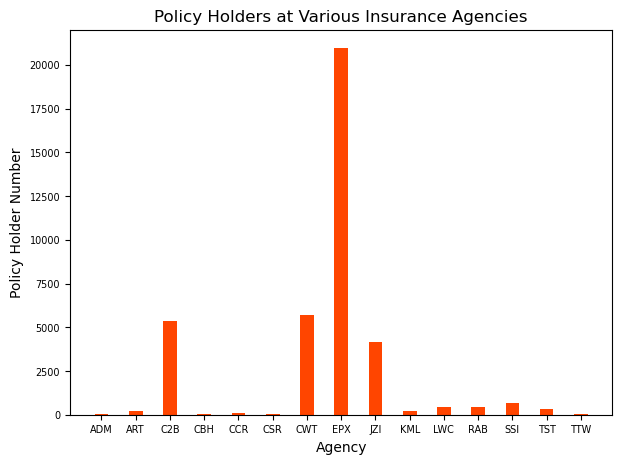

In [72]:
# Number of policyholder data who purchased insurance at each agency
display(ti.groupby('Agency')[['Agency']].size().reset_index().rename(columns = {0 : 'Policyholder Number'}).sort_values(by = 'Policyholder Number', ascending=False))

df = ti.groupby(by=['Agency']).size().reset_index(name='counts')
# Visualize policy holder at various agencies
fig = plt.figure(figsize = (7, 5))
plt.bar(df['Agency'], df['counts'], color ='orangered', width = 0.4)
plt.xticks(size=7)
plt.yticks(size=7)
plt.xlabel('Agency')
plt.ylabel('Policy Holder Number')
plt.title('Policy Holders at Various Insurance Agencies')
plt.show()

`Summary`

The commission given by the insurance company to travel agents **depends on the agreement between both parties**. So, it's **normal** for some agencies to **not receive** a commission **even with positive** net sales, while others still receive it when net sales are negative.

Most policyholder data comes from the EPX agency, with **20,961 records**. Since **EPX doesn't receive** a commission whether net sales are **positive or negative**, we won't remove agency data that still gets commissions when net sales are negative, as most of it involves EPX, and deleting it would result in losing a lot of information.

### 6.6 Normality Test for Numerical

In [75]:
# Apply normaltest to each column and collect the p-values
normality_results = ti.select_dtypes(include='number').apply(lambda col: normaltest(col.dropna())[1]).reset_index()
normality_results.columns = ['Column', 'p-value']
display(normality_results)
print(normality_results[normality_results['p-value']<=0.05]['Column'].unique())

,Column,p-value
0,Duration,0.0
1,Net Sales,0.0
2,Commision (in value),0.0
3,Age,0.0


['Duration' 'Net Sales' 'Commision (in value)' 'Age']


### 6.7 Multicolinearity

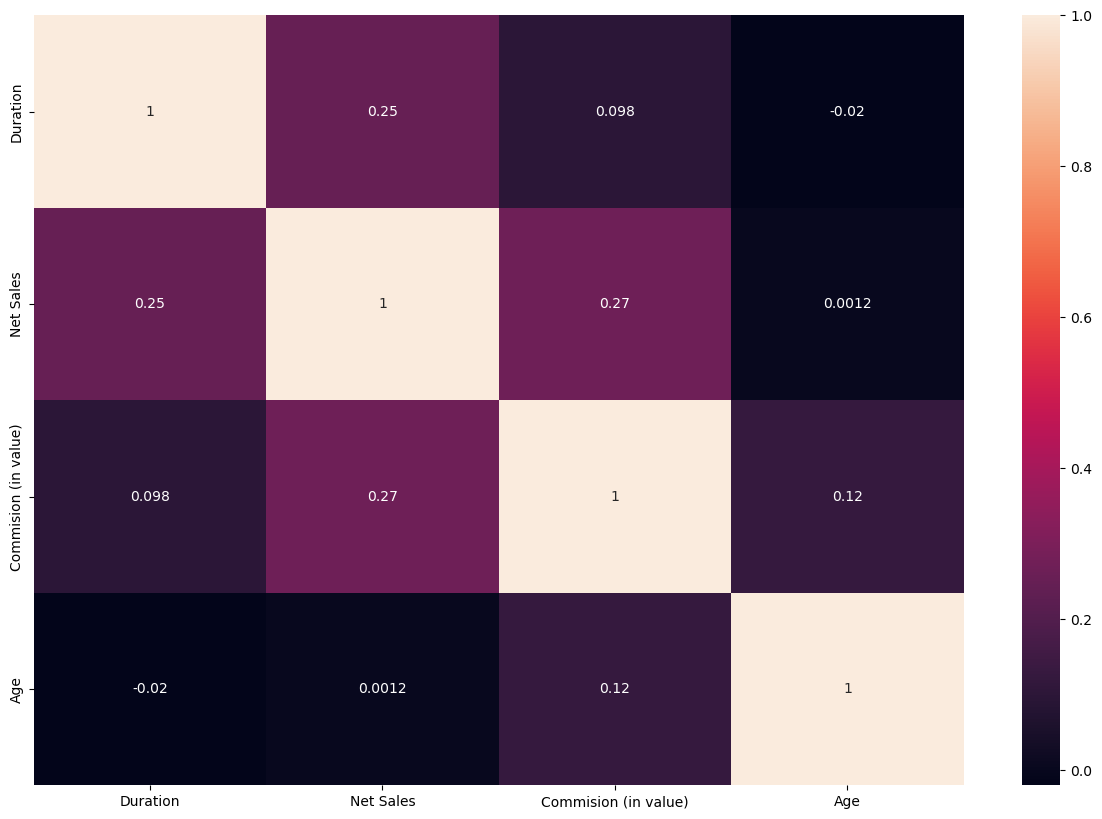

[['Duration', 'Duration'], ['Net Sales', 'Net Sales'], ['Commision (in value)', 'Commision (in value)'], ['Age', 'Age']]


In [84]:
plt.figure(figsize=(15,10))
sns.heatmap(ti.select_dtypes(include='number').corr(method='spearman'),annot=True)
plt.show()

dfcorr=ti.select_dtypes(include='number')
corrMatrix=dfcorr.corr(method='spearman')
already_in = set()
result = []
for col in corrMatrix:
    large_corr = corrMatrix[col][corrMatrix[col] >= 0.6 ].index.tolist()
    if large_corr and col not in already_in:
        already_in.update(set(large_corr))
        large_corr.append(col)
        result.append(large_corr)

print(result)

In [86]:
yes = ti[ti['Claim'] == 'Yes'].count()[1] 
print('Number of policyholders who made claims:', yes) 
no = ti[ti['Claim'] == 'No'].count()[1] 
print('Number of policyholders who did not make claims:', no)

Number of policyholders who made claims: 666
Number of policyholders who did not make claims: 38221


### 6.8 Feature Engineering
Several **feature engineering** steps will be applied, including **encoding** and **scaling**.

**1. Encoding**

After reviewing the dataset summary, all data types are correctly assigned. However, to simplify analysis and modeling, categorical data will be encoded, while numerical data won't undergo any preprocessing.

Here are the encoding methods to be applied:

- **Agency Type** and **Distribution Channel** each have only two unique values, so we'll apply **One-Hot Encoding**. We'll use the **Drop First** option to avoid multicollinearity, which is especially important for models like logistic regression to prevent overfitting.
- **Agency**, **Product Name**, and **Destination** have many unique values, so we will use **Binary Encoding** to handle these **nominal variables**.
- **No encoding is required for numerical variables** like **Duration**, **Net Sales**, **Commission (in value)**, and **Age**.

**2) Scaling** 

Scaling will only be applied for **Logistic Regression** and **KNN**, as these models rely on distance measures and assume normalized data. On the other hand, models such as **Decision Tree**, **Random Forest**, **XGBoost**, and **LightGBM** will **not use scaling**, as it may hinder their interpretability. Tree-based models do not require normalized data because they split data based on feature values, regardless of their scale.

Sources:

- [Analytics Vidhya: Feature Scaling – Normalization vs Standardization](https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/)
- [Machine Learning Approaches for Auto Insurance Big Data](https://www.mdpi.com/2227-9091/9/2/42)

[Rewiring Decision Making in Insurance with Data Science](https://www.bcg.com/publications/2018/rewiring-decision-making-insurance-data-science)

In [89]:
# Preprocessing
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile

# Imbalance Dataset
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Modeling 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

# Evaluation
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, precision_score, balanced_accuracy_score
from sklearn.metrics import roc_auc_score, RocCurveDisplay

#### 6.8.1 Encoding

In [92]:
onehot = OneHotEncoder(drop = 'first')
binary = ce.BinaryEncoder()

# Defining the variables
onehot_var = ['Agency Type','Distribution Channel','Claim']
binary_var = ['Agency','Product Name','Destination']

# Creating a ColumnTransformer
trans = ColumnTransformer([
    ('binary', binary, binary_var),
    ('one hot', onehot, onehot_var)
], remainder = 'passthrough')

trans

ColumnTransformer(remainder='passthrough',
                  transformers=[('binary', BinaryEncoder(),
                                 ['Agency', 'Product Name', 'Destination']),
                                ('one hot', OneHotEncoder(drop='first'),
                                 ['Agency Type', 'Distribution Channel',
                                  'Claim'])])

In [94]:
# Applying the transformations to the training data
ti_encoded = trans.fit_transform(ti)
ti_encoded = pd.DataFrame(ti_encoded)
ti_encoded

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,365.0,216.0,54.00,57.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,4.0,10.0,0.00,33.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,19.0,22.0,7.70,26.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,20.0,112.0,0.00,59.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,8.0,16.0,4.00,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38882,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,14.0,30.0,0.00,36.0
38883,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,17.0,79.2,47.52,47.0
38884,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,64.0,30.0,10.50,50.0
38885,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,51.0,36.0,0.00,36.0


In [95]:
# Feature names created by BinaryEncoder (first transformer) 
trans.transformers_[0][1].get_feature_names_out()

array(['Agency_0', 'Agency_1', 'Agency_2', 'Agency_3', 'Product Name_0',
       'Product Name_1', 'Product Name_2', 'Product Name_3',
       'Product Name_4', 'Destination_0', 'Destination_1',
       'Destination_2', 'Destination_3', 'Destination_4', 'Destination_5',
       'Destination_6', 'Destination_7'], dtype=object)

In [98]:
# Feature names created by OneHotEncoder (second transformer)
trans.transformers_[1][1].get_feature_names_out()

array(['Agency Type_Travel Agency', 'Distribution Channel_Online',
       'Claim_Yes'], dtype=object)

In [100]:
# Get Preprocessed columns name
feature_names = list(trans.transformers_[0][1].get_feature_names_out()) + list(trans.transformers_[1][1].get_feature_names_out()) + ['Duration', 'Net Sales', 'Commision (in value)', 'Age']
ti_encoded.columns = feature_names
ti_encoded

,Agency_0,Agency_1,Agency_2,Agency_3,Product Name_0,Product Name_1,Product Name_2,Product Name_3,Product Name_4,Destination_0,Destination_1,Destination_2,Destination_3,Destination_4,Destination_5,Destination_6,Destination_7,Agency Type_Travel Agency,Distribution Channel_Online,Claim_Yes,Duration,Net Sales,Commision (in value),Age
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,365.0,216.0,54.00,57.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,4.0,10.0,0.00,33.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,19.0,22.0,7.70,26.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,20.0,112.0,0.00,59.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,8.0,16.0,4.00,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38882,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,14.0,30.0,0.00,36.0
38883,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,17.0,79.2,47.52,47.0
38884,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,64.0,30.0,10.50,50.0
38885,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,51.0,36.0,0.00,36.0


In [102]:
# Renaming the column 'Claim_Yes' to 'Claim' after encoding
ti_encoded.rename({'Claim_Yes':'Claim'}, axis=1, inplace = True)
ti_encoded

,Agency_0,Agency_1,Agency_2,Agency_3,Product Name_0,Product Name_1,Product Name_2,Product Name_3,Product Name_4,Destination_0,Destination_1,Destination_2,Destination_3,Destination_4,Destination_5,Destination_6,Destination_7,Agency Type_Travel Agency,Distribution Channel_Online,Claim,Duration,Net Sales,Commision (in value),Age
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,365.0,216.0,54.00,57.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,4.0,10.0,0.00,33.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,19.0,22.0,7.70,26.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,20.0,112.0,0.00,59.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,8.0,16.0,4.00,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38882,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,14.0,30.0,0.00,36.0
38883,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,17.0,79.2,47.52,47.0
38884,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,64.0,30.0,10.50,50.0
38885,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,51.0,36.0,0.00,36.0


**Splitting Validation Data**

In [105]:
# Define Target & Feature
X = ti_encoded.drop(columns = 'Claim')
y = ti_encoded['Claim']
# Splitting
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify = y, test_size = 0.2, random_state = 2024)

In [119]:
print(X.shape[0])
print(f'Data Train number of rows: {X_train.shape[0]}')
print(f'Data Test number of rows:{X_test.shape[0]}')

38887
Data Train number of rows: 31109
Data Test number of rows:7778


#### 6.8.2 Scaling

In [157]:
# Define Scaler
scaler = RobustScaler()

### 6.9 Feature Selection
Feature selection helps **identify the most important features** that influence the target variable. Using **too many features** can lead to **overfitting**, while using **too few** can result in **underfitting**. The method being used for feature selection is **Select Percentile**.

In [160]:
X_train.shape[1]

23

`Explanation`

Now we have 23 features. Let's pick the 11 most important features that have an impact.

In [163]:
select = SelectPercentile(percentile= 50)
select.fit(X_train, y_train)

X_train_selected = select.transform(X_train)
X_test_selected = select.transform(X_test)

# Now there 11 feature selected
print(f'Selected feature: {X_train_selected.shape[1]}')

Selected feature: 11


**Check features name**

In [166]:
X.columns 

Index(['Agency_0', 'Agency_1', 'Agency_2', 'Agency_3', 'Product Name_0',
       'Product Name_1', 'Product Name_2', 'Product Name_3', 'Product Name_4',
       'Destination_0', 'Destination_1', 'Destination_2', 'Destination_3',
       'Destination_4', 'Destination_5', 'Destination_6', 'Destination_7',
       'Agency Type_Travel Agency', 'Distribution Channel_Online', 'Duration',
       'Net Sales', 'Commision (in value)', 'Age'],
      dtype='object')

In [168]:
feature_names_selected = ['Agency_0', 'Agency_1', 'Agency_2', 'Agency_3', 'Product Name_0',
       'Product Name_1', 'Product Name_2', 'Product Name_3', 'Product Name_4',
       'Destination_0', 'Destination_1', 'Destination_2', 'Destination_3',
       'Destination_4', 'Destination_5', 'Destination_6', 'Destination_7',
       'Agency Type_Travel Agency', 'Distribution Channel_Online', 'Duration',
       'Net Sales', 'Commision (in value)', 'Age']

In [170]:
# show selected feature
ti_selected = pd.DataFrame({
    'Fitur': feature_names_selected,
    'indikator': select.get_support()
})
ti_selected[ti_selected['indikator']==True]

,Fitur,indikator
2,Agency_2,True
3,Agency_3,True
5,Product Name_1,True
7,Product Name_3,True
8,Product Name_4,True
15,Destination_6,True
16,Destination_7,True
17,Agency Type_Travel Agency,True
19,Duration,True
20,Net Sales,True


`Explanation`

Based on the feature selection results, **Age** and **Distribution** Channel are not among the top 11 features influencing claim status. The influential numeric variables are **Duration**, **Net Sales**, and **Commission (in value)**. The influential categorical variables include **Agency Type**, **Agency**, **Product Name**, and **Destination**.

## **VII. Modeling & Evaluation** 

- We will use classification algorithms like **Logistic Regression, KNN, Decision Tree, XGBoost, and LightGBM** to predict if a policyholder will file a claim.
- To handle the imbalanced data, we’ll evaluate all models using **Pipeline and Stratified K-Fold Cross Validation**.
- The evaluation metrics will be **ROC-AUC and balanced accuracy**, as we’re interested in both classes and the data is imbalanced.
- We’ll evaluate the models in four ways:
1. Without oversampling or feature selection
2. Without oversampling but with feature selection
3. With oversampling but without feature selection
4. With oversampling and feature selection
- We’ll first test models with default hyperparameters and, based on their performance, proceed to hyperparameter tuning for the most stable models.

In [175]:
# Define model
logreg = LogisticRegression(random_state=2024)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=2024)
rf = RandomForestClassifier(random_state=2024)
xgb = XGBClassifier(random_state=2024)
lgbm = lgb.LGBMClassifier(random_state=2024)

In [177]:
# Define oversampling 
smote = SMOTE()

### 7.1 Cross Validation Logistic Regression and KNN (Hyperparameter default)

#### 7.1.1 Metric : ROC-AUC without feature selection

In [181]:
models = [logreg, knn]

rocauc_mean_with_sampling_noselect1 = []
rocauc_std_with_sampling_noselect1 = []
rocauc_mean_without_sampling_noselect1 = []
rocauc_std_without_sampling_noselect1 = []

for model in models :

    # modeling with oversampling
    pipe_model_with_sampling = Pipeline([
        ('scaler', scaler),
        ('resample', smote),
        ('algorithm', model)
    ])

    model_cv_with_sampling = cross_val_score(
        estimator = pipe_model_with_sampling,
        X = X_train,
        y = y_train,
        cv = StratifiedKFold(n_splits = 5),
        scoring = 'roc_auc',
        n_jobs = -1
    )
    rocauc_mean_with_sampling_noselect1.append(model_cv_with_sampling.mean())
    rocauc_std_with_sampling_noselect1.append(model_cv_with_sampling.std())

    # modeling without oversampling
    pipe_model_without_sampling = Pipeline([
        ('scaler', scaler),
        ('algorithm', model)
    ])

    model_cv_without_sampling = cross_val_score(
        estimator = pipe_model_without_sampling,
        X = X_train,
        y = y_train,
        cv = StratifiedKFold(n_splits = 5),
        scoring = 'roc_auc',
        n_jobs = -1
    )
    rocauc_mean_without_sampling_noselect1.append(model_cv_without_sampling.mean())
    rocauc_std_without_sampling_noselect1.append(model_cv_without_sampling.std())

In [182]:
pd.DataFrame({
    'model' : ['Logistic Regression', 'KNN'],
    'mean_rocauc_with_sampling' : rocauc_mean_with_sampling_noselect1,
    'mean_rocauc_without_sampling' : rocauc_mean_without_sampling_noselect1,
    'std_rocauc_with_sampling' : rocauc_std_with_sampling_noselect1,
    'std_rocauc_without_sampling' : rocauc_std_without_sampling_noselect1,
}).sort_values('mean_rocauc_with_sampling', ascending=False)

,model,mean_rocauc_with_sampling,mean_rocauc_without_sampling,std_rocauc_with_sampling,std_rocauc_without_sampling
0,Logistic Regression,0.812747,0.814978,0.022033,0.020984
1,KNN,0.677442,0.601929,0.025970,0.021423


#### 7.1.2 Metric : ROC-AUC with feature selection

In [184]:
models = [logreg, knn]

rocauc_mean_with_sampling_select1 = []
rocauc_std_with_sampling_select1 = []
rocauc_mean_without_sampling_select1 = []
rocauc_std_without_sampling_select1 = []

for model in models :

    # modeling with oversampling
    pipe_model_with_sampling = Pipeline([
        ('scaler', scaler),
        ('resample', smote),
        ('algorithm', model)
    ])

    model_cv_with_sampling = cross_val_score(
        estimator = pipe_model_with_sampling,
        X = X_train_selected,
        y = y_train,
        cv = StratifiedKFold(n_splits = 5),
        scoring = 'roc_auc',
        n_jobs = -1
    )
    rocauc_mean_with_sampling_select1.append(model_cv_with_sampling.mean())
    rocauc_std_with_sampling_select1.append(model_cv_with_sampling.std())

    # modeling without oversampling
    pipe_model_without_sampling = Pipeline([
        ('scaler', scaler),
        ('algorithm', model)
    ])

    model_cv_without_sampling = cross_val_score(
        estimator = pipe_model_without_sampling,
        X = X_train_selected,
        y = y_train,
        cv = StratifiedKFold(n_splits = 5),
        scoring = 'roc_auc',
        n_jobs = -1
    )
    rocauc_mean_without_sampling_select1.append(model_cv_without_sampling.mean())
    rocauc_std_without_sampling_select1.append(model_cv_without_sampling.std())

In [185]:
pd.DataFrame({
    'model' : ['Logistic Regression', 'KNN'],
    'mean_rocauc_with_sampling' : rocauc_mean_with_sampling_select1,
    'mean_rocauc_without_sampling' : rocauc_mean_without_sampling_select1,
    'std_rocauc_with_sampling' : rocauc_std_with_sampling_select1,
    'std_rocauc_without_sampling' : rocauc_std_without_sampling_select1,
}).sort_values('mean_rocauc_with_sampling', ascending=False)

,model,mean_rocauc_with_sampling,mean_rocauc_without_sampling,std_rocauc_with_sampling,std_rocauc_without_sampling
0,Logistic Regression,0.819985,0.819907,0.022448,0.019586
1,KNN,0.652211,0.621033,0.015980,0.013231


#### 7.1.3 Metric : Balanced accuracy without feature selection

In [187]:
models = [logreg, knn]

acc_mean_with_sampling_noselect1 = []
acc_std_with_sampling_noselect1 = []
acc_mean_without_sampling_noselect1 = []
acc_std_without_sampling_noselect1 = []

for model in models :

    # modeling with oversampling
    pipe_model_with_sampling = Pipeline([
        ('scaler', scaler),
        ('resample', smote),
        ('algorithm', model)
    ])

    model_cv_with_sampling = cross_val_score(
        estimator = pipe_model_with_sampling,
        X = X_train,
        y = y_train,
        cv = StratifiedKFold(n_splits = 5),
        scoring = 'balanced_accuracy',
        n_jobs = -1
    )
    acc_mean_with_sampling_noselect1.append(model_cv_with_sampling.mean())
    acc_std_with_sampling_noselect1.append(model_cv_with_sampling.std())

    # modeling without oversampling
    pipe_model_without_sampling = Pipeline([
        ('scaler', scaler),
        ('algorithm', model)
    ])

    model_cv_without_sampling = cross_val_score(
        estimator = pipe_model_without_sampling,
        X = X_train,
        y = y_train,
        cv = StratifiedKFold(n_splits = 5),
        scoring = 'balanced_accuracy',
        n_jobs = -1
    )
    acc_mean_without_sampling_noselect1.append(model_cv_without_sampling.mean())
    acc_std_without_sampling_noselect1.append(model_cv_without_sampling.std())

In [188]:
pd.DataFrame({
    'model' : ['Logistic Regression', 'KNN'],
    'mean_acc_with_sampling' : acc_mean_with_sampling_noselect1,
    'mean_acc_without_sampling' : acc_mean_without_sampling_noselect1,
    'std_acc_with_sampling' : acc_std_with_sampling_noselect1,
    'std_acc_without_sampling' : acc_std_without_sampling_noselect1,
}).sort_values('mean_acc_with_sampling', ascending=False)

,model,mean_acc_with_sampling,mean_acc_without_sampling,std_acc_with_sampling,std_acc_without_sampling
0,Logistic Regression,0.750012,0.499967,0.016598,0.000040
1,KNN,0.627607,0.503257,0.028541,0.003507


#### 7.1.4 Metric : Balanced accuracy with feature selection

In [190]:
models = [logreg, knn]

acc_mean_with_sampling_select1 = []
acc_std_with_sampling_select1 = []
acc_mean_without_sampling_select1 = []
acc_std_without_sampling_select1 = []

for model in models :

    # modeling with oversampling
    pipe_model_with_sampling = Pipeline([
        ('scaler', scaler),
        ('resample', smote),
        ('algorithm', model)
    ])

    model_cv_with_sampling = cross_val_score(
        estimator = pipe_model_with_sampling,
        X = X_train_selected,
        y = y_train,
        cv = StratifiedKFold(n_splits = 5),
        scoring = 'balanced_accuracy',
        n_jobs = -1
    )
    acc_mean_with_sampling_select1.append(model_cv_with_sampling.mean())
    acc_std_with_sampling_select1.append(model_cv_with_sampling.std())

    # modeling without oversampling
    pipe_model_without_sampling = Pipeline([
        ('scaler', scaler),
        ('algorithm', model)
    ])

    model_cv_without_sampling = cross_val_score(
        estimator = pipe_model_without_sampling,
        X = X_train_selected,
        y = y_train,
        cv = StratifiedKFold(n_splits = 5),
        scoring = 'balanced_accuracy',
        n_jobs = -1
    )
    acc_mean_without_sampling_select1.append(model_cv_without_sampling.mean())
    acc_std_without_sampling_select1.append(model_cv_without_sampling.std())

In [191]:
pd.DataFrame({
    'model' : ['Logistic Regression', 'KNN'],
    'mean_acc_with_sampling' : acc_mean_with_sampling_select1,
    'mean_acc_without_sampling' : acc_mean_without_sampling_select1,
    'std_acc_with_sampling' : acc_std_with_sampling_select1,
    'std_acc_without_sampling' : acc_std_without_sampling_select1,
}).sort_values('mean_acc_with_sampling', ascending=False)

,model,mean_acc_with_sampling,mean_acc_without_sampling,std_acc_with_sampling,std_acc_without_sampling
0,Logistic Regression,0.757201,0.499967,0.018659,0.000040
1,KNN,0.591292,0.509940,0.025501,0.001755


`Explanation`

Logistic Regression performs better than KNN on both metrics, with a small standard deviation (less than 0.03). The best mean value for Logistic Regression is seen with the roc_auc metric, using **SMOTE and feature selection**, achieving a mean of **0.821** before oversampling and **0.820** after. When using all features, the model scores **0.817** before oversampling and **0.814** after. This shows that feature selection slightly improves performance, but oversampling doesn’t have much impact. However, the increased standard deviation in Logistic Regression suggests less stability in the model, which is not ideal.

### 7.2 Cross Validation Tree Based Model (Hyperparameter default)

#### 7.2.1 Metric : ROC-AUC without feature selection

In [195]:
models = [dt, rf, xgb, lgbm]

rocauc_mean_with_sampling_noselect2 = []
rocauc_std_with_sampling_noselect2 = []
rocauc_mean_without_sampling_noselect2 = []
rocauc_std_without_sampling_noselect2 = []

for model in models :

    # modeling with oversampling
    pipe_model_with_sampling = Pipeline([
        ('resample', smote),
        ('algorithm', model)
    ])

    model_cv_with_sampling = cross_val_score(
        estimator = pipe_model_with_sampling,
        X = X_train,
        y = y_train,
        cv = StratifiedKFold(n_splits = 5),
        scoring = 'roc_auc',
        n_jobs = -1
    )
    rocauc_mean_with_sampling_noselect2.append(model_cv_with_sampling.mean())
    rocauc_std_with_sampling_noselect2.append(model_cv_with_sampling.std())

    # modeling without oversampling
    pipe_model_without_sampling = Pipeline([
        ('algorithm', model)
    ])

    model_cv_without_sampling = cross_val_score(
        estimator = pipe_model_without_sampling,
        X = X_train,
        y = y_train,
        cv = StratifiedKFold(n_splits = 5),
        scoring = 'roc_auc',
        n_jobs = -1
    )
    rocauc_mean_without_sampling_noselect2.append(model_cv_without_sampling.mean())
    rocauc_std_without_sampling_noselect2.append(model_cv_without_sampling.std())

In [196]:
pd.DataFrame({
    'model' : ['Desicion Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
    'mean_rocauc_with_sampling' : rocauc_mean_with_sampling_noselect2,
    'mean_rocauc_without_sampling' : rocauc_mean_without_sampling_noselect2,
    'std_rocauc_with_sampling' : rocauc_std_with_sampling_noselect2,
    'std_rocauc_without_sampling' : rocauc_std_without_sampling_noselect2,
}).sort_values('mean_rocauc_with_sampling', ascending=False)

,model,mean_rocauc_with_sampling,mean_rocauc_without_sampling,std_rocauc_with_sampling,std_rocauc_without_sampling
3,LightGBM,0.796335,0.790451,0.019382,0.024740
2,XGBoost,0.781923,0.763867,0.025760,0.023381
1,Random Forest,0.721193,0.695648,0.006059,0.003674
0,Desicion Tree,0.539996,0.528563,0.019673,0.007269


#### 7.2.2 Metric : ROC-AUC with feature selection

In [198]:
models = [dt, rf, xgb, lgbm]

rocauc_mean_with_sampling_select2 = []
rocauc_std_with_sampling_select2 = []
rocauc_mean_without_sampling_select2 = []
rocauc_std_without_sampling_select2 = []

for model in models :

    # modeling with oversampling
    pipe_model_with_sampling = Pipeline([
        ('resample', smote),
        ('algorithm', model)
    ])

    model_cv_with_sampling = cross_val_score(
        estimator = pipe_model_with_sampling,
        X = X_train_selected,
        y = y_train,
        cv = StratifiedKFold(n_splits = 5),
        scoring = 'roc_auc',
        n_jobs = -1
    )
    rocauc_mean_with_sampling_select2.append(model_cv_with_sampling.mean())
    rocauc_std_with_sampling_select2.append(model_cv_with_sampling.std())

    # modeling without oversampling
    pipe_model_without_sampling = Pipeline([
        ('algorithm', model)
    ])

    model_cv_without_sampling = cross_val_score(
        estimator = pipe_model_without_sampling,
        X = X_train_selected,
        y = y_train,
        cv = StratifiedKFold(n_splits = 5),
        scoring = 'roc_auc',
        n_jobs = -1
    )
    rocauc_mean_without_sampling_select2.append(model_cv_without_sampling.mean())
    rocauc_std_without_sampling_select2.append(model_cv_without_sampling.std())

In [199]:
pd.DataFrame({
    'model' : ['Desicion Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
    'mean_rocauc_with_sampling' : rocauc_mean_with_sampling_select2,
    'mean_rocauc_without_sampling' : rocauc_mean_without_sampling_select2,
    'std_rocauc_with_sampling' : rocauc_std_with_sampling_select2,
    'std_rocauc_without_sampling' : rocauc_std_without_sampling_select2,
}).sort_values('mean_rocauc_with_sampling', ascending=False)

,model,mean_rocauc_with_sampling,mean_rocauc_without_sampling,std_rocauc_with_sampling,std_rocauc_without_sampling
3,LightGBM,0.803741,0.793995,0.018922,0.015565
2,XGBoost,0.789892,0.779736,0.019499,0.017123
1,Random Forest,0.697309,0.677209,0.013794,0.009742
0,Desicion Tree,0.595388,0.587340,0.018485,0.018417


#### 7.2.3 Metric : Balance accuracy without feature selection

In [201]:
models = [dt, rf, xgb, lgbm]

acc_mean_with_sampling_noselect2 = []
acc_std_with_sampling_noselect2 = []
acc_mean_without_sampling_noselect2 = []
acc_std_without_sampling_noselect2 = []

for model in models :

    # modeling with oversampling
    pipe_model_with_sampling = Pipeline([
        ('resample', smote),
        ('algorithm', model)
    ])

    model_cv_with_sampling = cross_val_score(
        estimator = pipe_model_with_sampling,
        X = X_train,
        y = y_train,
        cv = StratifiedKFold(n_splits = 5),
        scoring = 'balanced_accuracy',
        n_jobs = -1
    )
    acc_mean_with_sampling_noselect2.append(model_cv_with_sampling.mean())
    acc_std_with_sampling_noselect2.append(model_cv_with_sampling.std())

    # modeling without oversampling
    pipe_model_without_sampling = Pipeline([
        ('algorithm', model)
    ])

    model_cv_without_sampling = cross_val_score(
        estimator = pipe_model_without_sampling,
        X = X_train,
        y = y_train,
        cv = StratifiedKFold(n_splits = 5),
        scoring = 'balanced_accuracy',
        n_jobs = -1
    )
    acc_mean_without_sampling_noselect2.append(model_cv_without_sampling.mean())
    acc_std_without_sampling_noselect2.append(model_cv_without_sampling.std())

In [202]:
pd.DataFrame({
    'model' : ['Desicion Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
    'mean_acc_with_sampling' : acc_mean_with_sampling_noselect2,
    'mean_acc_without_sampling' : acc_mean_without_sampling_noselect2,
    'std_acc_with_sampling' : acc_std_with_sampling_noselect2,
    'std_acc_without_sampling' : acc_std_without_sampling_noselect2,
}).sort_values('mean_acc_with_sampling', ascending=False)

,model,mean_acc_with_sampling,mean_acc_without_sampling,std_acc_with_sampling,std_acc_without_sampling
3,LightGBM,0.570907,0.503462,0.006890,0.003426
2,XGBoost,0.564984,0.503282,0.014940,0.003625
0,Desicion Tree,0.543751,0.521949,0.021462,0.011492
1,Random Forest,0.537130,0.507859,0.013665,0.009238


#### 7.2.4 Metric : Balance accuracy with feature selection

In [204]:
models = [dt, rf, xgb, lgbm]

acc_mean_with_sampling_select2 = []
acc_std_with_sampling_select2 = []
acc_mean_without_sampling_select2 = []
acc_std_without_sampling_select2 = []

for model in models :

    # modeling with oversampling
    pipe_model_with_sampling = Pipeline([
        ('resample', smote),
        ('algorithm', model)
    ])

    model_cv_with_sampling = cross_val_score(
        estimator = pipe_model_with_sampling,
        X = X_train_selected,
        y = y_train,
        cv = StratifiedKFold(n_splits = 5),
        scoring = 'balanced_accuracy',
        n_jobs = -1
    )
    acc_mean_with_sampling_select2.append(model_cv_with_sampling.mean())
    acc_std_with_sampling_select2.append(model_cv_with_sampling.std())

    # modeling without oversampling
    pipe_model_without_sampling = Pipeline([
        ('algorithm', model)
    ])

    model_cv_without_sampling = cross_val_score(
        estimator = pipe_model_without_sampling,
        X = X_train_selected,
        y = y_train,
        cv = StratifiedKFold(n_splits = 5),
        scoring = 'balanced_accuracy',
        n_jobs = -1
    )
    acc_mean_without_sampling_select2.append(model_cv_without_sampling.mean())
    acc_std_without_sampling_select2.append(model_cv_without_sampling.std())

In [205]:
pd.DataFrame({
    'model' : ['Desicion Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
    'mean_acc_with_sampling' : acc_mean_with_sampling_select2,
    'mean_acc_without_sampling' : acc_mean_without_sampling_select2,
    'std_acc_with_sampling' : acc_std_with_sampling_select2,
    'std_acc_without_sampling' : acc_std_without_sampling_select2,
}).sort_values('mean_acc_with_sampling', ascending=False)

,model,mean_acc_with_sampling,mean_acc_without_sampling,std_acc_with_sampling,std_acc_without_sampling
3,LightGBM,0.628519,0.502567,0.014407,0.003746
2,XGBoost,0.619444,0.503511,0.021868,0.001842
1,Random Forest,0.557917,0.510051,0.013838,0.002344
0,Desicion Tree,0.557177,0.519588,0.019776,0.007424


`Explanation`

The cross-validation results show that the **tree-based models** perform better with the **ROC-AUC** metric than with balanced accuracy. **LightGBM** has the highest average ROC-AUC score, reaching **0.812** after oversampling and feature selection. However, oversampling and feature selection don’t significantly impact the model’s performance.

The top model candidates are **Logistic Regression and LightGBM**. Next, we'll assess the stability of these models using the ROC-AUC metric and compare their performance with and without oversampling, and with/without feature selection.

### 7.3 Check Model Performance on Train and Test Set

#### 7.3.1 Logistic Regression and KNN (Hyperparameter default) without oversampling and without feature selection

In [211]:
models = [logreg, knn]
rocauc_test_without_sampling_noselect1 = []
rocauc_train_without_sampling_noselect1 = []

def y_pred_func(model):
    estimator = Pipeline([
        ('scaler', scaler),
        ('algorithm', model)
    ])
    
    estimator.fit(X_train,y_train)
    return estimator

for model in models:
    estimator = y_pred_func(model)
    y_pred_test = estimator.predict(X_test)
    y_pred_train = estimator.predict(X_train)
    rocauc_test_without_sampling_noselect1.append(roc_auc_score(y_test,y_pred_test))
    rocauc_train_without_sampling_noselect1.append(roc_auc_score(y_train,y_pred_train))

In [212]:
pd.DataFrame({'model':['Logistic Regression', 'KNN'],
             'rocauc score (train set)': rocauc_train_without_sampling_noselect1,
             'rocauc score (validation set)': rocauc_mean_without_sampling_noselect1,
             'rocauc score (test set)': rocauc_test_without_sampling_noselect1}).set_index('model').sort_values(by='rocauc score (validation set)',ascending=False)

,rocauc score (train set),rocauc score (validation set),rocauc score (test set)
model,,,
Logistic Regression,0.499967,0.814978,0.500000
KNN,0.515751,0.601929,0.503302


#### 7.3.2 Logistic Regression and KNN (Hyperparameter default) without oversampling & with feature selection

In [214]:
models = [logreg, knn]
rocauc_test_without_sampling_select1 = []
rocauc_train_without_sampling_select1 = []

def y_pred_func(model):
    estimator = Pipeline([
        ('scaler', scaler),
        ('algorithm', model)
    ])
    
    estimator.fit(X_train_selected,y_train)
    return estimator

for model in models:
    estimator = y_pred_func(model)
    y_pred_test = estimator.predict(X_test_selected)
    y_pred_train = estimator.predict(X_train_selected)
    rocauc_test_without_sampling_select1.append(roc_auc_score(y_test,y_pred_test))
    rocauc_train_without_sampling_select1.append(roc_auc_score(y_train,y_pred_train))

In [215]:
pd.DataFrame({'model':['Logistic Regression', 'KNN'],
             'rocauc score (train set)': rocauc_train_without_sampling_select1,
             'rocauc score (validation set)': rocauc_mean_without_sampling_noselect1,
             'rocauc score (test set)': rocauc_test_without_sampling_select1}).set_index('model').sort_values(by='rocauc score (validation set)',ascending=False)

,rocauc score (train set),rocauc score (validation set),rocauc score (test set)
model,,,
Logistic Regression,0.499967,0.814978,0.500000
KNN,0.521314,0.601929,0.503367


#### 7.3.3 Logistic Regression and KNN (Hyperparameter default) with oversampling & without feature selection

In [217]:
models = [logreg, knn]
rocauc_test_with_sampling_noselect1 = []
rocauc_train_with_sampling_noselect1 = []

def y_pred_func(model):
    estimator = Pipeline([
        ('scaler', scaler),
        ('resample', smote),
        ('algorithm', model)
    ])
    
    estimator.fit(X_train,y_train)
    return estimator

for model in models:
    estimator = y_pred_func(model)
    y_pred_test = estimator.predict(X_test)
    y_pred_train = estimator.predict(X_train)
    rocauc_test_with_sampling_noselect1.append(roc_auc_score(y_test,y_pred_test))
    rocauc_train_with_sampling_noselect1.append(roc_auc_score(y_train,y_pred_train))

In [218]:
pd.DataFrame({'model':['Logistic Regression', 'KNN'],
             'rocauc score (train set)': rocauc_train_with_sampling_noselect1,
             'rocauc score (validation set)': rocauc_mean_with_sampling_noselect1,
             'rocauc score (test set)': rocauc_test_with_sampling_noselect1}).set_index('model').sort_values(by='rocauc score (validation set)',ascending=False)

,rocauc score (train set),rocauc score (validation set),rocauc score (test set)
model,,,
Logistic Regression,0.759848,0.812747,0.750608
KNN,0.958697,0.677442,0.618355


#### 7.3.4 Logistic Regression and KNN (Hyperparameter default) with oversampling & with feature selection

In [220]:
models = [logreg, knn]
rocauc_test_with_sampling_select1 = []
rocauc_train_with_sampling_select1 = []

def y_pred_func(model):
    estimator = Pipeline([
        ('scaler', scaler),
        ('resample', smote),
        ('algorithm', model)
    ])
    
    estimator.fit(X_train_selected,y_train)
    return estimator

for model in models:
    estimator = y_pred_func(model)
    y_pred_test = estimator.predict(X_test_selected)
    y_pred_train = estimator.predict(X_train_selected)
    rocauc_test_with_sampling_select1.append(roc_auc_score(y_test,y_pred_test))
    rocauc_train_with_sampling_select1.append(roc_auc_score(y_train,y_pred_train))

In [221]:
pd.DataFrame({'model':['Logistic Regression', 'KNN'],
             'rocauc score (train set)': rocauc_train_with_sampling_select1,
             'rocauc score (validation set)': rocauc_mean_with_sampling_select1,
             'rocauc score (test set)': rocauc_test_with_sampling_select1}).set_index('model').sort_values(by='rocauc score (validation set)',ascending=False)

,rocauc score (train set),rocauc score (validation set),rocauc score (test set)
model,,,
Logistic Regression,0.760714,0.819985,0.751981
KNN,0.807887,0.652211,0.556604


`Explanation`

The performance of **Logistic Regression and KNN models was poor** during training and testing without oversampling, indicating underfitting. After oversampling, **Logistic Regression** performed quite stably:

Without feature selection: **0.76** in training, **0.82** in validation, and **0.73** on the test set
With feature selection: **0.76** in training, **0.82** in validation, and **0.74** on the test set
Meanwhile, **KNN became very overfitted** after applying the **SMOTE** method.

In conclusion, **Logistic Regression with oversampling and feature selection is a strong candidate** for hyperparameter tuning due to its better test performance.

#### 7.3.5 Tree based model (Hyperparameter default) without sampling & without feature selection

In [226]:
models = [dt, rf, xgb, lgbm]
rocauc_test_without_sampling_noselect2 = []
rocauc_train_without_sampling_noselect2 = []

def y_pred_func(model):
    estimator = Pipeline([
        ('algorithm', model)
    ])
    
    estimator.fit(X_train,y_train)
    return estimator

for model in models:
    estimator = y_pred_func(model)
    y_pred_test = estimator.predict(X_test)
    y_pred_train = estimator.predict(X_train)
    rocauc_test_without_sampling_noselect2 .append(roc_auc_score(y_test,y_pred_test))
    rocauc_train_without_sampling_noselect2 .append(roc_auc_score(y_train,y_pred_train))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 533, number of negative: 30576
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 31109, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017133 -> initscore=-4.049449
[LightGBM] [Info] Start training from score -4.049449


In [227]:
pd.DataFrame({'model':['Desicion Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
             'rocauc score (train set)': rocauc_train_without_sampling_noselect2 ,
             'rocauc score (validation set)': rocauc_mean_without_sampling_noselect2,
             'rocauc score (test set)': rocauc_test_without_sampling_noselect2 }).set_index('model').sort_values(by='rocauc score (validation set)',ascending=False)

,rocauc score (train set),rocauc score (validation set),rocauc score (test set)
model,,,
LightGBM,0.532833,0.790451,0.499869
XGBoost,0.552516,0.763867,0.499935
Random Forest,0.954874,0.695648,0.498561
Desicion Tree,0.950281,0.528563,0.521311


#### 7.3.6 Tree based model (Hyperparameter default) without sampling & with feature selection

In [229]:
models = [dt, rf, xgb, lgbm]
rocauc_test_without_sampling_select2 = []
rocauc_train_without_sampling_select2 = []

def y_pred_func(model):
    estimator = Pipeline([
        ('algorithm', model)
    ])
    
    estimator.fit(X_train_selected,y_train)
    return estimator

for model in models:
    estimator = y_pred_func(model)
    y_pred_test = estimator.predict(X_test_selected)
    y_pred_train = estimator.predict(X_train_selected)
    rocauc_test_without_sampling_select2 .append(roc_auc_score(y_test,y_pred_test))
    rocauc_train_without_sampling_select2 .append(roc_auc_score(y_train,y_pred_train))

[LightGBM] [Info] Number of positive: 533, number of negative: 30576
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 31109, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017133 -> initscore=-4.049449
[LightGBM] [Info] Start training from score -4.049449


In [230]:
pd.DataFrame({'model':['Desicion Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
             'rocauc score (train set)': rocauc_train_without_sampling_select2 ,
             'rocauc score (validation set)': rocauc_mean_without_sampling_select2,
             'rocauc score (test set)': rocauc_test_without_sampling_select2 }).set_index('model').sort_values(by='rocauc score (validation set)',ascending=False)

,rocauc score (train set),rocauc score (validation set),rocauc score (test set)
model,,,
LightGBM,0.514055,0.793995,0.499869
XGBoost,0.516853,0.779736,0.499935
Random Forest,0.750289,0.677209,0.498038
Desicion Tree,0.744759,0.587340,0.498854


#### 7.3.7 Tree based model (Hyperparameter default) with sampling & without feature selection

In [232]:
models = [dt, rf, xgb, lgbm]
rocauc_test_with_sampling_noselect2 = []
rocauc_train_with_sampling_noselect2 = []

def y_pred_func(model):
    estimator = Pipeline([
        ('resample', smote),
        ('algorithm', model)
    ])
    
    estimator.fit(X_train,y_train)
    return estimator

for model in models:
    estimator = y_pred_func(model)
    y_pred_test = estimator.predict(X_test)
    y_pred_train = estimator.predict(X_train)
    rocauc_test_with_sampling_noselect2.append(roc_auc_score(y_test,y_pred_test))
    rocauc_train_with_sampling_noselect2.append(roc_auc_score(y_train,y_pred_train))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 30576, number of negative: 30576
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5593
[LightGBM] [Info] Number of data points in the train set: 61152, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [233]:
pd.DataFrame({'model':['Desicion Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
             'rocauc score (train set)': rocauc_train_with_sampling_noselect2,
             'rocauc score (validation set)': rocauc_mean_with_sampling_noselect2,
             'rocauc score (test set)': rocauc_test_with_sampling_noselect2}).set_index('model').sort_values(by='rocauc score (validation set)',ascending=False)

,rocauc score (train set),rocauc score (validation set),rocauc score (test set)
model,,,
LightGBM,0.677329,0.796335,0.559884
XGBoost,0.727453,0.781923,0.545207
Random Forest,0.974246,0.721193,0.515558
Desicion Tree,0.950281,0.539996,0.528338


#### 7.3.8 Tree based model (Hyperparameter default) with sampling & with feature selection

In [235]:
models = [dt, rf, xgb, lgbm]
rocauc_test_with_sampling_select2 = []
rocauc_train_with_sampling_select2 = []

def y_pred_func(model):
    estimator = Pipeline([
        ('resample', smote),
        ('algorithm', model)
    ])
    
    estimator.fit(X_train_selected,y_train)
    return estimator

for model in models:
    estimator = y_pred_func(model)
    y_pred_test = estimator.predict(X_test_selected)
    y_pred_train = estimator.predict(X_train_selected)
    rocauc_test_with_sampling_select2.append(roc_auc_score(y_test,y_pred_test))
    rocauc_train_with_sampling_select2.append(roc_auc_score(y_train,y_pred_train))

[LightGBM] [Info] Number of positive: 30576, number of negative: 30576
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 61152, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [236]:
pd.DataFrame({'model':['Desicion Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
             'rocauc score (train set)': rocauc_train_with_sampling_select2,
             'rocauc score (validation set)': rocauc_mean_with_sampling_select2,
             'rocauc score (test set)': rocauc_test_with_sampling_select2}).set_index('model').sort_values(by='rocauc score (validation set)',ascending=False)

,rocauc score (train set),rocauc score (validation set),rocauc score (test set)
model,,,
LightGBM,0.732660,0.803741,0.589857
XGBoost,0.767253,0.789892,0.591296
Random Forest,0.839306,0.697309,0.533406
Desicion Tree,0.818107,0.595388,0.533144


#### 7.3.8 Model Performance Comparison

In [238]:
df1 = pd.DataFrame({'model':['Logistic Regression', 'KNN'],
             'rocauc score (train set)': rocauc_train_with_sampling_select1,
             'rocauc score (validation set)': rocauc_mean_with_sampling_select1,
             'rocauc score (test set)': rocauc_test_with_sampling_select1})
df2 = pd.DataFrame({'model':['Desicion Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
             'rocauc score (train set)': rocauc_train_with_sampling_select2,
             'rocauc score (validation set)': rocauc_mean_with_sampling_select2,
             'rocauc score (test set)': rocauc_test_with_sampling_select2})

df = pd.concat([df1, df2], ignore_index=True)

In [239]:
df.set_index('model').sort_values(by='rocauc score (validation set)',ascending=False)

,rocauc score (train set),rocauc score (validation set),rocauc score (test set)
model,,,
Logistic Regression,0.760714,0.819985,0.751981
LightGBM,0.732660,0.803741,0.589857
XGBoost,0.767253,0.789892,0.591296
Random Forest,0.839306,0.697309,0.533406
KNN,0.807887,0.652211,0.556604
Desicion Tree,0.818107,0.595388,0.533144


`Explanation`

None of the **tree-based models performed well**, even after oversampling. They all showed overfitting, with good training results but poor test performance. Therefore, **Logistic Regression (with resampling and feature selection) will move forward to hyperparameter tuning**, as it was the most stable and performed best across training, validation, and testing compared to the other models.

## **VIII. Hyperparameter Tuning: Logistic Regression**

Hyperparameter tuning is performed to find the optimal model settings to improve performance. Below are the training and testing results prior to hyperparameter tuning.

### 8.1 Model Before Tuning : Logistic Regression with oversampling, feature selection, scaling, and hyperparameter default

In [358]:
# Train dan Test score awal
logreg = LogisticRegression(random_state=2024)
rocauc_test_with_sampling_select1 = []
rocauc_train_with_sampling_select1 = []

estimator = Pipeline([
    ('scaler', scaler),
    ('resample', smote),
    ('algorithm', logreg)
])
    
estimator.fit(X_train_selected,y_train)

estimator = y_pred_func(logreg)
y_pred_test = estimator.predict(X_test_selected)
y_pred_train = estimator.predict(X_train_selected)
print(f'Train score before tuning: {roc_auc_score(y_train,y_pred_train)}')
print(f'Test score before tuning: {roc_auc_score(y_test,y_pred_test)}\n')
# Classification report
print(estimator,'\n', classification_report(y_test,y_pred_test))

Train score before tuning: 0.757794252785542
Test score before tuning: 0.7523419405282337

Pipeline(steps=[('resample', SMOTE()),
                ('algorithm', LogisticRegression(random_state=2024))]) 
               precision    recall  f1-score   support

         0.0       0.99      0.83      0.90      7645
         1.0       0.06      0.68      0.12       133

    accuracy                           0.83      7778
   macro avg       0.53      0.75      0.51      7778
weighted avg       0.98      0.83      0.89      7778



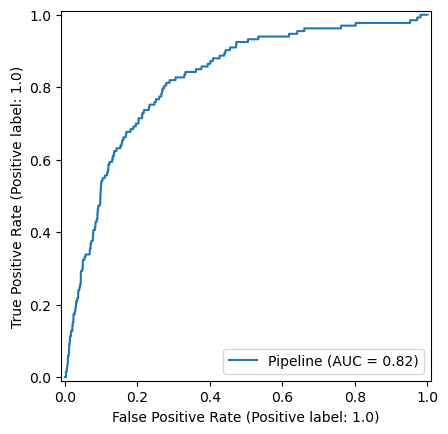

In [282]:
# Visualisasi ROC-AUC
RocCurveDisplay.from_estimator(estimator, X_test_selected, y_test)

`Explanation`

The area (AUC) under the line is 0.82. As the AUC value approaches 0.5, the model performance worsens.

In [285]:
print (f'Model Accuracy before tuning - : {estimator.score(X_train_selected,y_train):.3f}')

Model Accuracy before tuning - : 0.822


### 8.2 Penalized Model

In [326]:
# Train dan Test score awal
logreg = LogisticRegression(class_weight = 'balanced',random_state=2024)

estimator = Pipeline([
    ('scaler', scaler),
    ('resample', smote),
    ('algorithm', logreg)
])
    
estimator.fit(X_train_selected,y_train)

estimator = y_pred_func(logreg)
y_pred_test = estimator.predict(X_test_selected)
y_pred_train = estimator.predict(X_train_selected)
print(f'Train score before tuning: {roc_auc_score(y_train,y_pred_train)}')
print(f'Test score before tuning: {roc_auc_score(y_test,y_pred_test)}\n')
print(estimator,'\n', classification_report(y_test,y_pred_test))

Train score before tuning: 0.7561693532947888
Test score before tuning: 0.7513609071730996

Pipeline(steps=[('resample', SMOTE()),
                ('algorithm',
                 LogisticRegression(class_weight='balanced',
                                    random_state=2024))]) 
               precision    recall  f1-score   support

         0.0       0.99      0.83      0.90      7645
         1.0       0.06      0.68      0.12       133

    accuracy                           0.82      7778
   macro avg       0.53      0.75      0.51      7778
weighted avg       0.98      0.82      0.89      7778



In [292]:
print (f'Model Accuracy before tuning: {estimator.score(X_train_selected,y_train):.3f}')

Model Accuracy before tuning: 0.824


`Explanation`

It's clear that the penalized model does not improve the model's performance.

### 8.3 Hyperparameter Tuning with Grid Search

Hyperparameter tuning will be conducted using the GridSearch method by testing the following combinations:

- solver: lbfgs, newton-cg, liblinear, sag, saga
- C values: 1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005
- max iterations: 100, 200, 300, 400, 500, 1000
- penalty: l1, l2, elasticnet, none

In [296]:
# model
smote = SMOTE()
model = LogisticRegression()
pipe_model = Pipeline ([
            ('scaler', scaler),
            ('balance', smote),
            ('clf', model)
])

#metode cross validation
skf = StratifiedKFold(n_splits=5)

#hyperparameter
hyperparam = {
    'clf__penalty':['l1', 'l2', 'elasticnet', 'none'],
    'clf__C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005],
    'clf__solver':['lbfgs','newton-cg','liblinear','sag','saga'],
    'clf__max_iter' : [100,200,300,400,500,1000]
}

grid_search = GridSearchCV(
    pipe_model,
    param_grid = hyperparam, 
    cv = skf,
    scoring = 'roc_auc',
    n_jobs = -1
)

model_tuned = grid_search.fit(X_train_selected, y_train)
model_tuned
# default : C=1.0, solver=lbfgs, balance__k_neighbors = 5

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('balance', SMOTE()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__C': [1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1,
                                    0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001,
                                    5e-05],
                         'clf__max_iter': [100, 200, 300, 400, 500, 1000],
                         'clf__penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'clf__solver': ['lbfgs', 'newton-cg', 'liblinear',
                                         'sag', 'saga']},
             scoring='roc_auc')

In [297]:
best_tuning = model_tuned.best_estimator_

In [298]:
print(model_tuned.best_score_)
print(model_tuned.best_params_)

0.8222672160201124
{'clf__C': 0.001, 'clf__max_iter': 300, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}


In [299]:
result = pd.DataFrame(model_tuned.cv_results_)
result[result['rank_test_score']==1].head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__max_iter,param_clf__penalty,param_clf__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1482,0.610219,0.058888,0.029582,0.015897,0.001,300,l1,liblinear,"{'clf__C': 0.001, 'clf__max_iter': 300, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}",0.834076,0.794606,0.812436,0.822664,0.847554,0.822267,0.018115,1


`Explanation`

After tuning, the model with the best mean value has the following hyperparameters: 'C': 0.001, 'max_iter': 300, 'penalty': 'l1', 'solver': 'liblinear'. The mean test score is **0.822**, with a standard deviation of **0.018**.

Before confirming this as the best model, let's compare the **recall, precision, roc-auc, and accuracy values**.

### 8.4 Comparison Model Before & After Tuning

#### 8.4.1 Before Tuning

In [361]:
estimator = Pipeline([
    ('scaler', scaler),
    ('resample', smote),
    ('algorithm', logreg)
])
    
estimator.fit(X_train_selected,y_train)
estimator = y_pred_func(logreg)
y_pred_test = estimator.predict(X_test_selected)
y_pred_train = estimator.predict(X_train_selected)
print(f'Train score before tuning: {roc_auc_score(y_train,y_pred_train)}')
print(f'Test score before tuning: {roc_auc_score(y_test,y_pred_test)}')

Train score before tuning: 0.7586565583081263
Test score before tuning: 0.7509030916073703


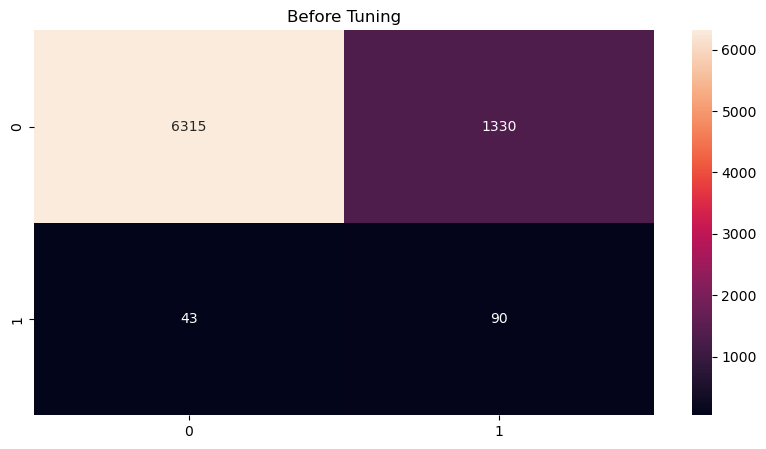

Recall: 0.6766917293233082
Precision: 0.06338028169014084
ROC: 0.7513609071730996
Accuracy: 0.7513609071730996


In [346]:
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt=".0f")
plt.title('Before Tuning')
plt.show()

# Score
print('Recall:', recall_score(y_test, y_pred_test))
print('Precision:', precision_score(y_test, y_pred_test))
print('ROC:', roc_auc_score(y_test, y_pred_test))
print('Accuracy:', balanced_accuracy_score(y_test, y_pred_test))

#### 8.4.2 After Tuning

In [363]:
best_tuning.fit(X_train_selected, y_train)
Y_pred_train = best_tuning.predict(X_train_selected)
Y_pred_test = best_tuning.predict(X_test_selected)

print(f'Train score after tuning: {roc_auc_score(y_train,Y_pred_train)}')
print(f'Test score after tuning: {roc_auc_score(y_test,Y_pred_test)}')

Train score after tuning: 0.761663061096859
Test score after tuning: 0.7468456950092695


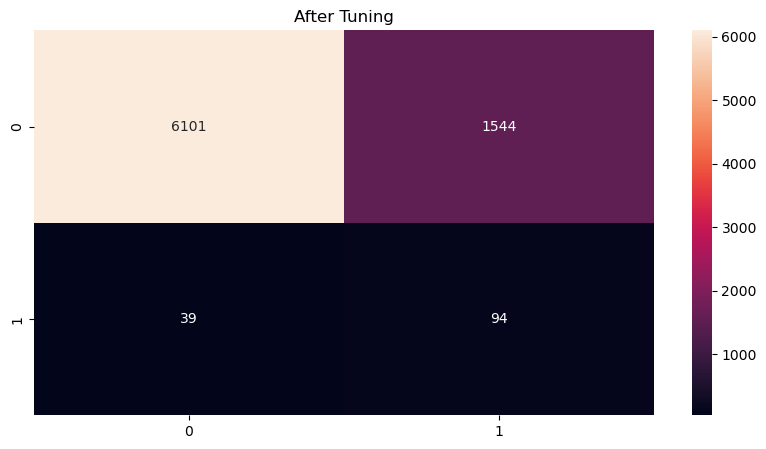

Recall: 0.706766917293233
Precision: 0.057387057387057384
ROC: 0.7524024252914824
Accuracy: 0.7524024252914825


In [348]:
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_test, Y_pred_test), annot=True, fmt=".0f")
plt.title('After Tuning')
plt.show()

# Score
print('Recall:', recall_score(y_test, Y_pred_test))
print('Precision:', precision_score(y_test, Y_pred_test))
print('ROC:', roc_auc_score(y_test, Y_pred_test))
print('Accuracy:', balanced_accuracy_score(y_test, Y_pred_test))

The logistic regression model before tuning performed better than after tuning. Here’s a summary of the confusion matrix results for the test set:

- **True Positives (TP)**: 90 policyholders were correctly predicted to file a claim.
- **False Negatives (FN)**: 43 policyholders who claimed were incorrectly predicted not to file a claim.
- **True Negatives (TN)**: 6,310 policyholders who didn’t claim were correctly predicted not to file.
- **False Positives (FP)**: 1,335 policyholders were incorrectly predicted to file a claim.

Overall, the predictions were:
- **Total predicted to claim**: 1,425 (1,335 FP + 90 TP)
- **Total predicted not to claim**: 6,353 (6,310 TN + 43 FN)

Evaluation results:

- **Recall**: Only 70.67% of actual claimants were correctly predicted.
- **Precision**: Only 5.73% of those predicted to claim actually did.
- **ROC and Accuracy**: The model correctly predicted 75.24% of all policyholders.

Therefore, the pre-tuning model (scaled logistic regression with SMOTE oversampling and feature selection) will be used.

**Saving model**

In [352]:
# Save model
pickle.dump(estimator, open('LogRegModel.pkl', 'wb'))

## **IX. Conclusion**

- The current machine learning model isn't performing well, so it’s advisable to retest it using different classification algorithms and a wider range of hyperparameters. If the results remain unsatisfactory, adding more features related to claim status could improve the data quality. Ultimately, even the best model will struggle if the data doesn't adequately support it.

- This model is valid only for data values within the following ranges; using it outside these limits will invalidate its predictions:

  - Age: 0 to 88
  - Net sales: -357.5 to 682.0
  - Duration: 0 to 547
  - Commission: 0.0 to 262.76

## **X. Recommendation**

**Product Sales Recommendations**:

To boost sales, it's important to target a **wide age range**. However, a broader demographic can also lead to more claims, so selecting policyholders carefully based on their **health, criminal history, travel destinations, and claim types is crucial**. Factors like the **mode of transportation (airplane, train, bus) and specific destinations (such as hotels or cities) may influence claim status more than age.

Insurance companies should keep **promoting travel insurance** through airlines and travel agencies, as many travelers fly both domestically and internationally. The **five products with the highest claim** ratios—Annual Silver Plan, Annual Gold Plan, Annual Travel Protect Gold, Single Trip Travel Protect Platinum, and Spouse or Parents Comprehensive Plan—indicate a strong demand for long-term travel insurance. If profits from these products aren't meeting goals, the company should consider marketing other options.

Additionally, the company should expand its **coverage to popular destinations**. The top ten countries frequently visited by Singaporeans include Singapore, Thailand, Malaysia, China, Indonesia, Australia, the US, Hong Kong, the Philippines, and Japan. Assessing the safety of these destinations could help reduce claims.

**Suggestions for Improving the Model**:

Add new features related to claim status, such as **policyholder names, order times, pricing, and insurance terms (like covered ages and trip lengths)** to allow for better data cleaning.

Test different machine learning **algorithms and retune hyperparameters**, exploring other oversampling methods like **Random Over Sampling** or SMOTENC.

Use **additional metrics** and try different classification algorithms, such as **CATBoost, Gradient Boosting, and AdaBoost**.